# Observe reconstruction fidelity

In [346]:
import os
import random
import sys
from datetime import datetime
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

In [2]:
path = "/Users/M283455/VAE_prject/scripts/"
sys.path.insert(0, path)

In [3]:
import VAE_tybalt
from VAE_tybalt import VAE

In [4]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [5]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

Load data

In [6]:
tcga_tybalt_file_location = "../../VAE_prject_data/raw/rnaseq_df_test.csv"
rnaseq_df = pd.read_csv(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1, inplace=True)
rnaseq_df = rnaseq_df.dropna()

In [25]:
best_100_genes = list(gene_summary_sort.index[:100])

In [47]:
worst_100_genes = list(gene_summary_sort.index[-100:])

Compute reconstruction losses

Permutation and adding noise

In [267]:
# Each row is shuffled randomly
def shuffle_random_subset_rows(df, subset_size):
    """
    Shuffles a random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    for i in range(len(df_shuffled)):
        subset_cols = np.random.choice(num_cols, subset_size, replace=False)
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(
            df_shuffled.iloc[i, subset_cols]
        )
    return df_shuffled

In [268]:
rnaseq_df.shape[1]

5000

In [269]:
# 1 percent of data shuffeled
rnaseq_df_1_shuffle_random = shuffle_random_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.01)
)

# 3.0 percent of data shuffeled
rnaseq_df_3_shuffle_random = shuffle_random_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.05)
)

# 5.0 percent of data shuffeled
rnaseq_df_5_shuffle_random = shuffle_random_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.10)
)

# 8.0 percent of data shuffeled
rnaseq_df_8_shuffle_random = shuffle_random_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.30)
)

# 10.0 percent of data shuffeled
rnaseq_df_10_shuffle_random = shuffle_random_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.50)
)

# 20.0 percent of data shuffeled
rnaseq_df_20_shuffle_random = shuffle_random_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.80)
)

In [270]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_1_rs = model.forward(
    torch.tensor(rnaseq_df_1_shuffle_random.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_1_rs = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_1_rs.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_3_rs = model.forward(
    torch.tensor(rnaseq_df_3_shuffle_random.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_3_rs = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_3_rs.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_5_rs = model.forward(
    torch.tensor(rnaseq_df_5_shuffle_random.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_5_rs = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_5_rs.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_8_rs = model.forward(
    torch.tensor(rnaseq_df_8_shuffle_random.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_8_rs = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_8_rs.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_10_rs = model.forward(
    torch.tensor(rnaseq_df_10_shuffle_random.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_10_rs = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_10_rs.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_20_rs = model.forward(
    torch.tensor(rnaseq_df_20_shuffle_random.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_20_rs = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_20_rs.detach().numpy(), columns=rnaseq_df.columns
)

In [300]:
# compute losses
def compute_losses(rnaseq_df, input_rnaseq_reconstruct):
    BCE_loss = []
    MSE_loss = []
    KLD_loss = []
    for i in range(len(rnaseq_df)):
        x = torch.Tensor(rnaseq_df.iloc[i].values)
        y = torch.Tensor(input_rnaseq_reconstruct.iloc[i].values)
        bce_loss = F.binary_cross_entropy(x, y)
        mse_loss = F.mse_loss(x, y)

        # prior = MultivariateNormal(loc = torch.zeros(model.forward(x)[1].mean.shape[1])
        #                           ,scale_tril=torch.eye(vae.forward(x)[1].mean.shape[1]))

        # kld_loss = torch.sum(kl_divergence(x, prior).item())
        BCE_loss.append(bce_loss.numpy().item())
        MSE_loss.append(mse_loss.numpy().item())

    return BCE_loss, MSE_loss

In [301]:
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5_rs)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10_rs)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0]))

1.4035129270749611
1.390797559748872
1.3975967218953382
1.4184416728254485
1.4537280795679037
1.7419378519286162


In [302]:
max(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1])

0.03877134248614311

In [303]:
# Each row is shuffled identically
import numpy as np
import pandas as pd


def shuffle_same_subset_rows(df, subset_size):
    """
    Shuffles the same random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    subset_cols = np.random.choice(num_cols, subset_size, replace=False)
    for i in range(len(df_shuffled)):
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(
            df_shuffled.iloc[i, subset_cols]
        )
    return df_shuffled

In [304]:
# 1 percent of data shuffeled
rnaseq_df_1_same_subset = shuffle_same_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.01)
)

# 3.0 percent of data shuffeled
rnaseq_df_3_same_subset = shuffle_same_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.05)
)

# 5.0 percent of data shuffeled
rnaseq_df_5_same_subset = shuffle_same_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.10)
)

# 8.0 percent of data shuffeled
rnaseq_df_8_same_subset = shuffle_same_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.30)
)

# 10.0 percent of data shuffeled
rnaseq_df_10_same_subset = shuffle_same_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.50)
)

# 20.0 percent of data shuffeled
rnaseq_df_20_same_subset = shuffle_same_subset_rows(
    rnaseq_df, int(rnaseq_df.shape[1] * 0.80)
)

In [305]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_1_ss = model.forward(
    torch.tensor(rnaseq_df_1.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_1_ss = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_1_ss.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_3_ss = model.forward(
    torch.tensor(rnaseq_df_3_same_subset.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_3_ss = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_3_ss.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_5_ss = model.forward(
    torch.tensor(rnaseq_df_5_same_subset.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_5_ss = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_5_ss.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_8_ss = model.forward(
    torch.tensor(rnaseq_df_8_same_subset.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_8_ss = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_8_ss.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_10_ss = model.forward(
    torch.tensor(rnaseq_df_10_same_subset.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_10_ss = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_10_ss.detach().numpy(), columns=rnaseq_df.columns
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_df_20_ss = model.forward(
    torch.tensor(rnaseq_df_20.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_df_20_ss = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_df_20_ss.detach().numpy(), columns=rnaseq_df.columns
)

In [306]:
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5_ss)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10_ss)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[0]))

1.4035129270749611
1.407702139755052
1.394832855998672
1.4035665566959983
1.4527834381758598
1.74700486665702


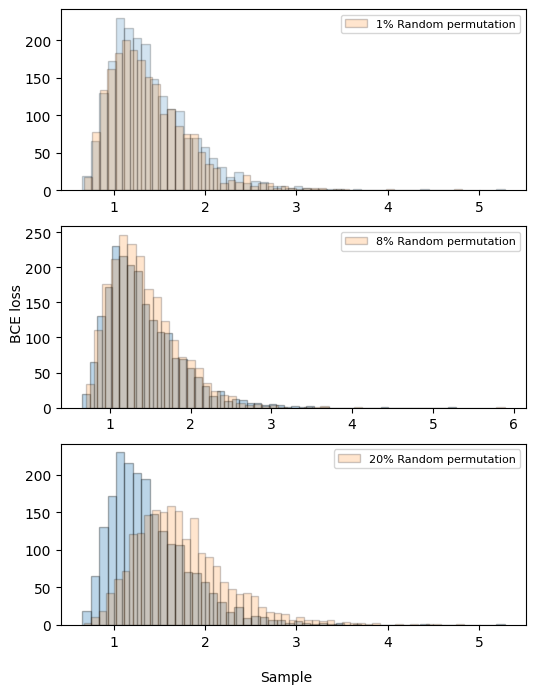

In [307]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="1% Random permutation",
)
ax1.legend(fontsize=8)

ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="8% Random permutation",
)
ax2.legend(fontsize=8)

ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="20% Random permutation",
)
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, "Sample", ha="center")
# Add a shared y-axis label
fig.text(0.04, 0.5, "BCE loss", va="center", rotation="vertical")

# Show the figure
plt.show()

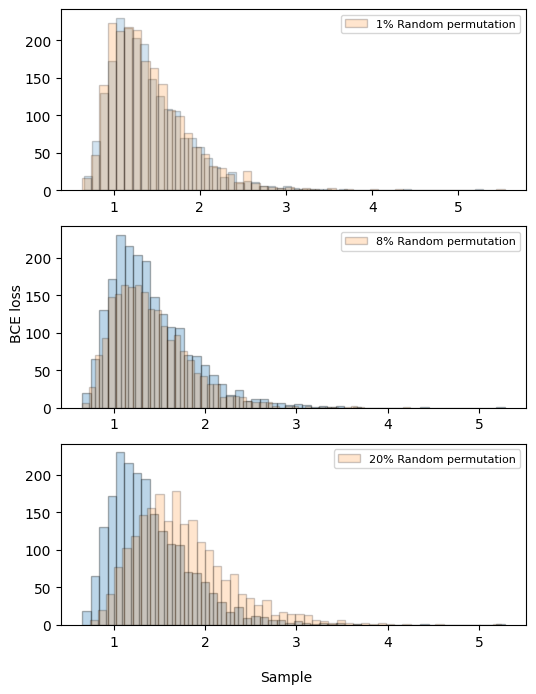

In [308]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="1% Random permutation",
)
ax1.legend(fontsize=8)

ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="8% Random permutation",
)
ax2.legend(fontsize=8)

ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="20% Random permutation",
)
ax3.legend(fontsize=8)

# Add a shared x-axis label
fig.text(0.5, 0.04, "Sample", ha="center")
# Add a shared y-axis label
fig.text(0.04, 0.5, "BCE loss", va="center", rotation="vertical")

# Show the figure
plt.show()

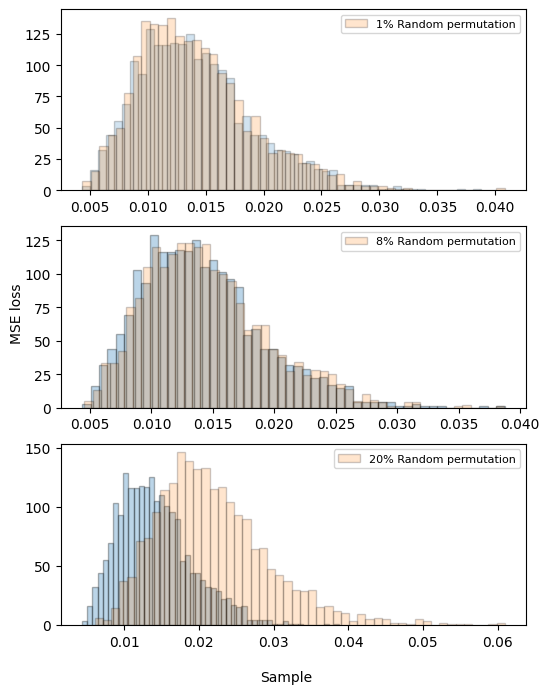

In [309]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="1% Random permutation",
)
ax1.legend(fontsize=8)

ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="8% Random permutation",
)
ax2.legend(fontsize=8)

ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="20% Random permutation",
)
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, "Sample", ha="center")
# Add a shared y-axis label
fig.text(0.04, 0.5, "MSE loss", va="center", rotation="vertical")

# Show the figure
plt.show()

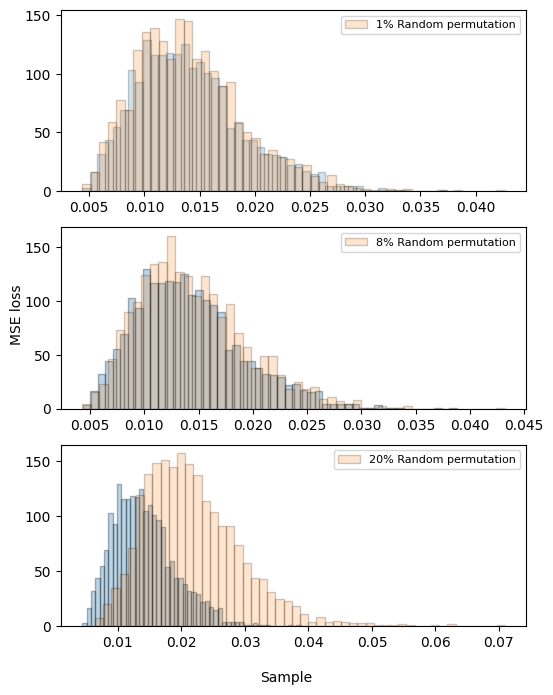

In [310]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="1% Random permutation",
)
ax1.legend(fontsize=8)

ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="8% Random permutation",
)
ax2.legend(fontsize=8)

ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="20% Random permutation",
)
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, "Sample", ha="center")
# Add a shared y-axis label
fig.text(0.04, 0.5, "MSE loss", va="center", rotation="vertical")

# Show the figure
plt.show()

Add Gaussian noise to genes

In [311]:
import numpy as np
import pandas as pd


def add_gaussian_noise(dataframe, mean=0, std_dev=1):
    """
    Adds Gaussian noise to each element of a pandas DataFrame.

    Args:
    dataframe: pandas DataFrame to add noise to.
    mean: Mean of the Gaussian distribution (default: 0)
    std_dev: Standard deviation of the Gaussian distribution (default: 1)

    Returns:
    pandas DataFrame with added Gaussian noise
    """
    noisy_dataframe = dataframe.applymap(lambda x: x + np.random.normal(mean, std_dev))
    return noisy_dataframe

In [312]:
rnaseq_df_noisy_0p1 = add_gaussian_noise(rnaseq_df, mean=0, std_dev=0.1)
rnaseq_df_noisy_0p3 = add_gaussian_noise(rnaseq_df, mean=0, std_dev=0.3)
rnaseq_df_noisy_0p6 = add_gaussian_noise(rnaseq_df, mean=0, std_dev=0.6)
rnaseq_df_noisy_0p9 = add_gaussian_noise(rnaseq_df, mean=0, std_dev=0.9)

In [313]:
# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_noisy_0p1 = model.forward(
    torch.tensor(rnaseq_df_noisy_0p1.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_noisy_0p1 = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_noisy_0p1.detach().numpy(),
    columns=rnaseq_df.columns,
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_noisy_0p3 = model.forward(
    torch.tensor(rnaseq_df_noisy_0p3.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_noisy_0p3 = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_noisy_0p3.detach().numpy(),
    columns=rnaseq_df.columns,
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_noisy_0p6 = model.forward(
    torch.tensor(rnaseq_df_noisy_0p6.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_noisy_0p6 = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_noisy_0p6.detach().numpy(),
    columns=rnaseq_df.columns,
)

# How well does the model reconstruct the input RNAseq data
input_rnaseq_reconstruct_tensor_noisy_0p9 = model.forward(
    torch.tensor(rnaseq_df_noisy_0p9.values, dtype=torch.float32)
)[0]
input_rnaseq_reconstruct_noisy_0p9 = pd.DataFrame(
    input_rnaseq_reconstruct_tensor_noisy_0p9.detach().numpy(),
    columns=rnaseq_df.columns,
)

In [314]:
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p3)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[0]))
print(np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0]))

1.4035129270749611
1.4022376792608666
1.4063075713343192
1.466934262196147
1.547133966596587


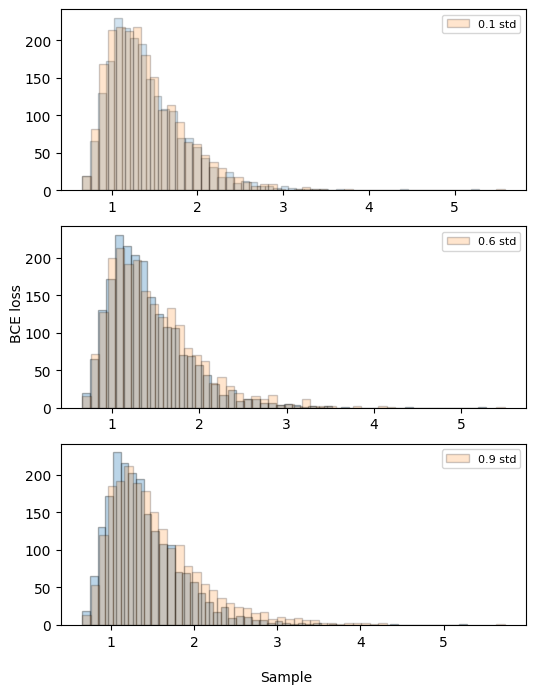

In [315]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)
ax1.legend(fontsize=8)

ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.6 std",
)
ax2.legend(fontsize=8)

ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.9 std",
)
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, "Sample", ha="center")
# Add a shared y-axis label
fig.text(0.04, 0.5, "BCE loss", va="center", rotation="vertical")

# Show the figure
plt.show()

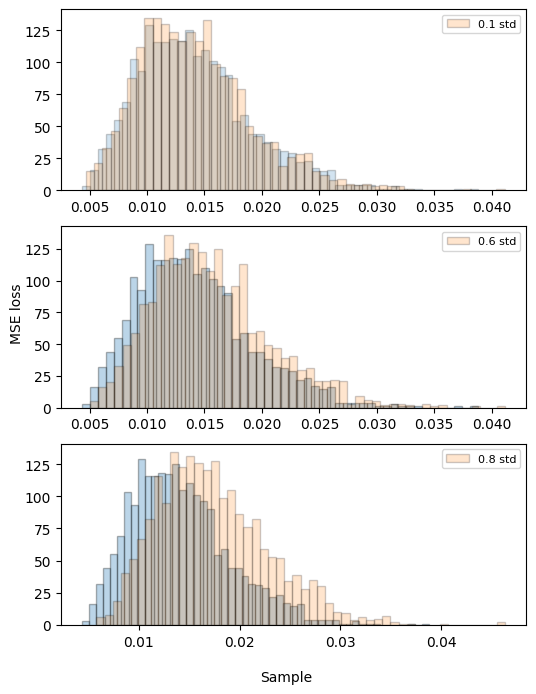

In [316]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6, 8))

# Plot the data on each subplot

ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
ax1.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)
ax1.legend(fontsize=8)

ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax2.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.6 std",
)
ax2.legend(fontsize=8)

ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.3,
)
ax3.hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.8 std",
)
ax3.legend(fontsize=8)


# Add a shared x-axis label
fig.text(0.5, 0.04, "Sample", ha="center")
# Add a shared y-axis label
fig.text(0.04, 0.5, "MSE loss", va="center", rotation="vertical")

# Show the figure
plt.show()

Compute mean

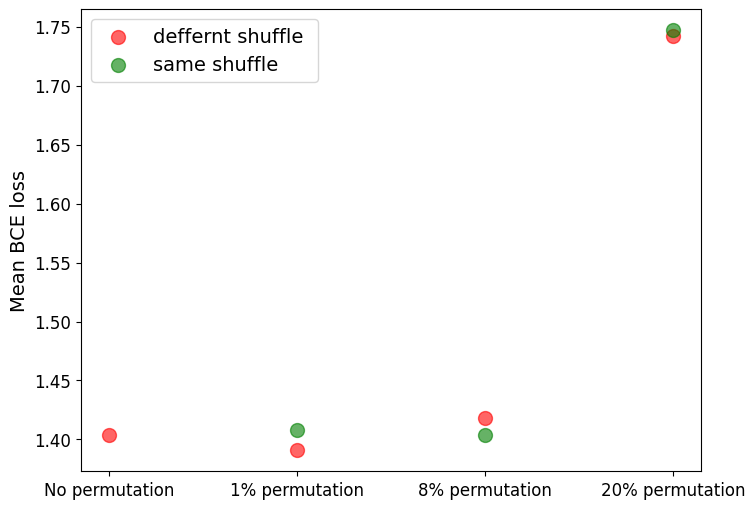

<Figure size 640x480 with 0 Axes>

In [317]:
## compare the performance here
plt.figure(figsize=(8, 6))

plt.scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0])],
    c="r",
    s=100,
    alpha=0.6,
    label="deffernt shuffle ",
)
plt.scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0])],
    c="r",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[0])],
    c="r",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0])],
    c="r",
    s=100,
    alpha=0.6,
)


plt.scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_ss)[0])],
    c="g",
    s=100,
    alpha=0.6,
    label="same shuffle",
)
plt.scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_ss)[0])],
    c="g",
    s=100,
    alpha=0.6,
)
plt.scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_ss)[0])],
    c="g",
    s=100,
    alpha=0.6,
)
plt.legend(fontsize=14)

plt.yticks(fontsize=12)
plt.xticks(
    [0, 1, 2, 3],
    ["No permutation", "1% permutation", "8% permutation", "20% permutation"],
    fontsize=12,
)

plt.ylabel("Mean BCE loss", fontsize=14)
plt.show()
plt.savefig("results/BCE_gene_loss.png")

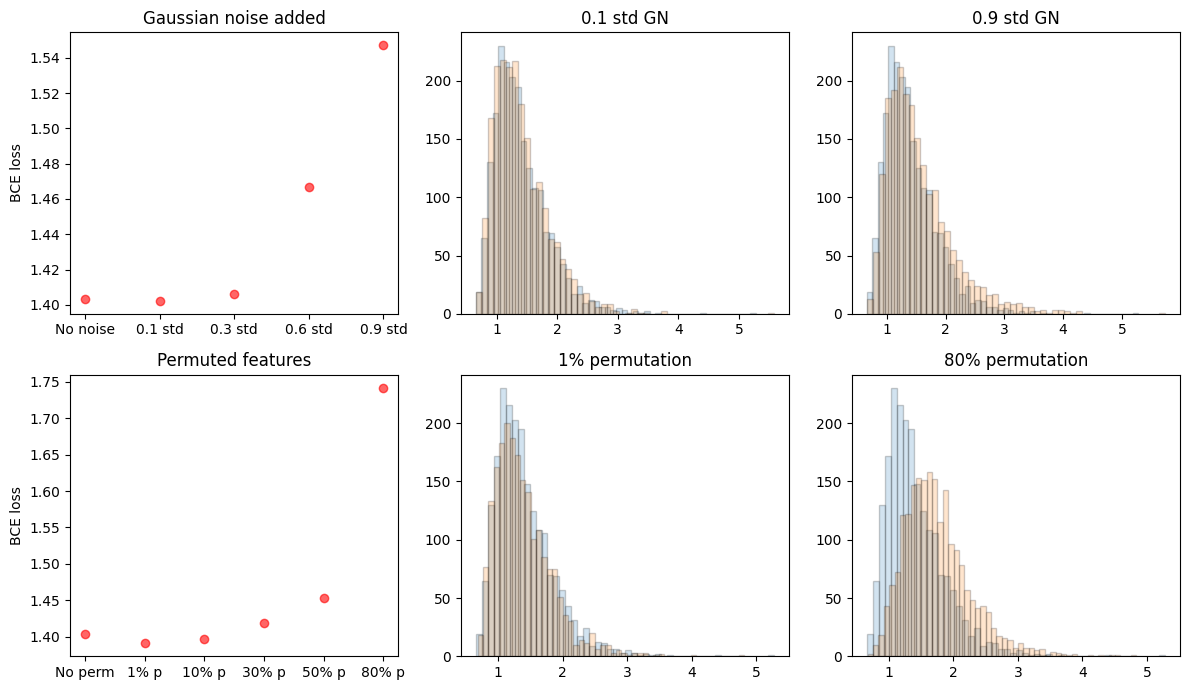

In [321]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

# Plot data on each subplot
axs[0, 0].scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0])],
    c="r",
    alpha=0.6,
    label="Mean MSE",
)
axs[0, 0].scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0])],
    c="r",
    alpha=0.6,
)
axs[0, 0].scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p3)[0])],
    c="r",
    alpha=0.6,
)
axs[0, 0].scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[0])],
    c="r",
    alpha=0.6,
)
axs[0, 0].scatter(
    [4],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0])],
    c="r",
    alpha=0.6,
)

# axs[0, 0].set_ylim(6000, 9000)
axs[0, 0].set_ylabel("BCE loss")
axs[0, 0].set_xticks(
    [0, 1, 2, 3, 4], ["No noise", "0.1 std", "0.3 std", "0.6 std", "0.9 std"]
)
axs[0, 0].set_title("Gaussian noise added")

axs[0, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[0, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)

axs[0, 1].set_title("0.1 std GN")
axs[0, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[0, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)
# axs[0, 1].plot(x, y2)
axs[0, 2].set_title("0.9 std GN")
# Plot data on each subplot
axs[1, 0].scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0])],
    c="r",
    alpha=0.6,
    label="Mean MSE",
)
axs[1, 0].scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5_rs)[0])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[0])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [4],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10_rs)[0])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [5],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0])],
    c="r",
    alpha=0.6,
)
# axs[1, 0].set_ylim(6000, 9000)

axs[1, 0].set_ylabel("BCE loss")
axs[1, 0].set_title("Permuted features")
axs[1, 0].set_xticks(
    [0, 1, 2, 3, 4, 5], ["No perm", "1% p", "10% p", "30% p", "50% p", "80% p"]
)

axs[1, 1].set_title("1% permutation")
axs[1, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[1, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)

axs[1, 2].set_title("80% permutation")
axs[1, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[1, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[0],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)
# Set a tight layout
fig.tight_layout()
plt.savefig("data/Mean_BCE_gene_plots.png")
# Display the plots
plt.show()

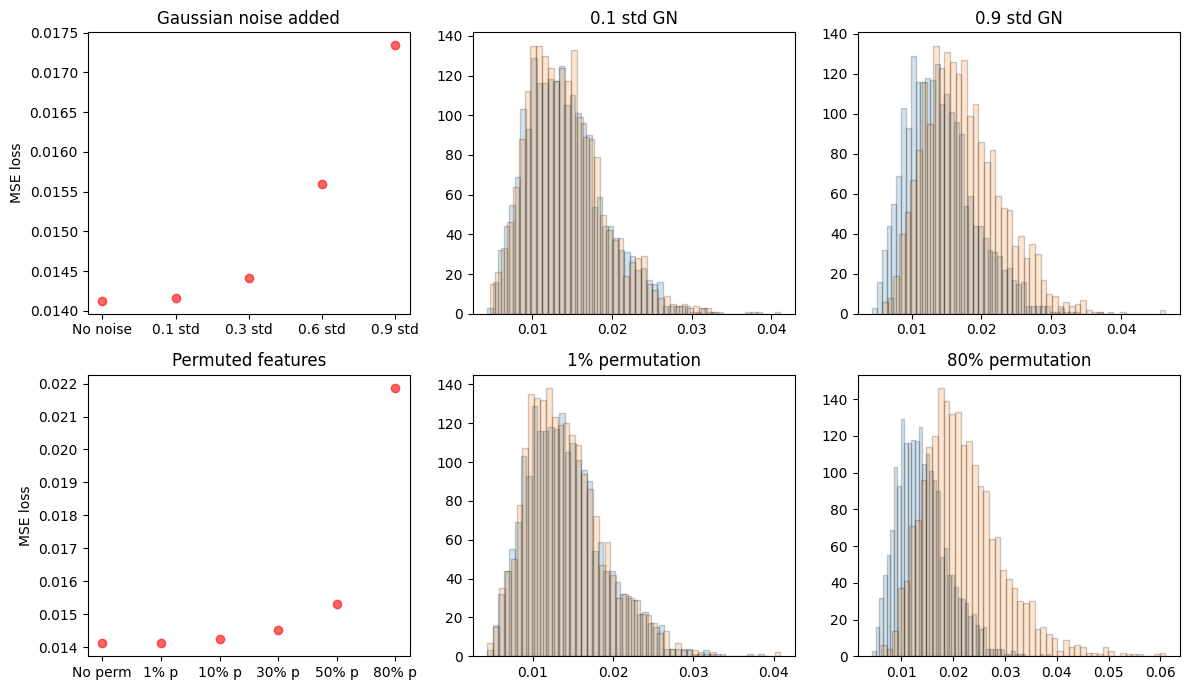

In [322]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 7))

# Plot data on each subplot
axs[0, 0].scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1])],
    c="r",
    alpha=0.6,
    label="Mean MSE",
)
axs[0, 0].scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[1])],
    c="r",
    alpha=0.6,
)
axs[0, 0].scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p3)[1])],
    c="r",
    alpha=0.6,
)
axs[0, 0].scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p6)[1])],
    c="r",
    alpha=0.6,
)
axs[0, 0].scatter(
    [4],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[1])],
    c="r",
    alpha=0.6,
)

# axs[0, 0].set_ylim(70, 120)
axs[0, 0].set_ylabel("MSE loss")
axs[0, 0].set_xticks(
    [0, 1, 2, 3, 4], ["No noise", "0.1 std", "0.3 std", "0.6 std", "0.9 std"]
)
axs[0, 0].set_title("Gaussian noise added")

axs[0, 1].set_title("0.1 std GN")
axs[0, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[0, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p1)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)

axs[0, 2].set_title("0.9 std GN")
axs[0, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[0, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_noisy_0p9)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)
# axs[0, 1].plot(x, y2)
# axs[0, 2].set_title("Reconstructed with VAE")
# Plot data on each subplot
axs[1, 0].scatter(
    [0],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1])],
    c="r",
    alpha=0.6,
    label="Mean MSE",
)
axs[1, 0].scatter(
    [1],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[1])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [2],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_5_rs)[1])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [3],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_8_rs)[1])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [4],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_10_rs)[1])],
    c="r",
    alpha=0.6,
)
axs[1, 0].scatter(
    [5],
    [np.mean(compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[1])],
    c="r",
    alpha=0.6,
)
# axs[1, 0].set_ylim(70, 120)

axs[1, 0].set_ylabel("MSE loss")
axs[1, 0].set_title("Permuted features")
axs[1, 0].set_xticks(
    [0, 1, 2, 3, 4, 5], ["No perm", "1% p", "10% p", "30% p", "50% p", "80% p"]
)

# axs[1, 1].imshow(permuted_img_tensor.detach().view(1, 28, 28).permute(1, 2, 0))
axs[1, 1].set_title("1% permutation")
axs[1, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[1, 1].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_1_rs)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)

axs[1, 2].set_title("80% permutation")
axs[1, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
)
axs[1, 2].hist(
    compute_losses(rnaseq_df, input_rnaseq_reconstruct_df_20_rs)[1],
    bins=50,
    edgecolor="black",
    alpha=0.2,
    label="0.1 std",
)
# Set a tight layout
# Set a tight layout
fig.tight_layout()
plt.savefig("data/Mean_MSE_gene_plots.png")
# Display the plots
plt.show()

In [323]:
input_rnaseq_reconstruct.max().max()

0.98907906

### Compare models trained with noisy datasets

In [107]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [108]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

## Results

In [303]:
# load model
def load_trained_model(model, model_name):
    model.load_state_dict(torch.load("../output/models/" + model_name))
    return model


# reconstruct the input dataframe with VAE
def VAE_reconstruct_df(df, model):
    reconstruct_tensor = model.forward(torch.tensor(df.values, dtype=torch.float32))[0]
    dataframe = pd.DataFrame(reconstruct_tensor.detach().numpy(), columns=df.columns)

    return dataframe


# How well does the model reconstruct the input RNAseq data
def VAE_latent_out(df):
    mu = model.forward(torch.tensor(df.values, dtype=torch.float32))[2]
    sigma = model.forward(torch.tensor(df.values, dtype=torch.float32))[3]

    column_names = [str(i) for i in range(100)]

    mu = pd.DataFrame(mu.detach().numpy(), columns=column_names)
    sigma = pd.DataFrame(sigma.detach().numpy(), columns=column_names)

    return mu, sigma


def gene_summary(df, df_reconstruct):
    reconstruction_fidelity = df - df_reconstruct

    gene_mean = reconstruction_fidelity.mean(axis=0)
    gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
    gene_summary = pd.DataFrame(
        [gene_mean, gene_abssum], index=["gene mean", "gene abs(sum)"]
    ).T
    gene_summary = gene_summary.sort_values(by="gene abs(sum)", ascending=True)

    return gene_summary


# plot histograms for the genes which have best recontructions
def plot_histograms_best_genes(df, model):
    # Define the number of rows and columns in the subplot grid
    num_rows = 6
    num_cols = 4

    df_reconstruct = VAE_reconstruct_df(df, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    best_500_genes = list(gene_summary_sort.index[:500])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[best_500_genes[70 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="blue",
            linewidth=1,
        )
        ax.hist(
            df_reconstruct[best_500_genes[70 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="green",
            linewidth=1,
        )
        ax.set_title(f"gene: {str(best_500_genes[70+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(["input", "reconstructed"], fontsize="8", loc="upper left")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()


# plot histograms for the genes which have best recontructions
def plot_histograms_worst_genes(df, model):
    # Define the number of rows and columns in the subplot grid
    num_rows = 6
    num_cols = 4

    df_reconstruct = VAE_reconstruct_df(df, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    worst_500_genes = list(gene_summary_sort.index[-500:])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[worst_500_genes[460 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="blue",
            linewidth=1,
        )
        ax.hist(
            df_reconstruct[worst_500_genes[460 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="green",
            linewidth=1,
        )
        ax.set_title(f"gene: {str(worst_500_genes[460+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(["input", "reconstructed"], fontsize="8", loc="upper left")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

#### Gene reconstruction using trained VAE without any noise

In [304]:
models = os.listdir("../output/models/")
print(models)

['65vae_weights.pth', 'tcga_rnaseq_df_0p20vae_weights.pth', 'tcga_rnaseq_df_0p100vae_weights.pth', 'vae_weights.pth', 'tcga_rnaseq_df_0p40vae_weights.pth', 'tcga_rnaseq_df_0p1vae_weights.pth', 'tcga_rnaseq_df_0p60vae_weights.pth', 'tcga_rnaseq_df_0p80vae_weights.pth']


In [305]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

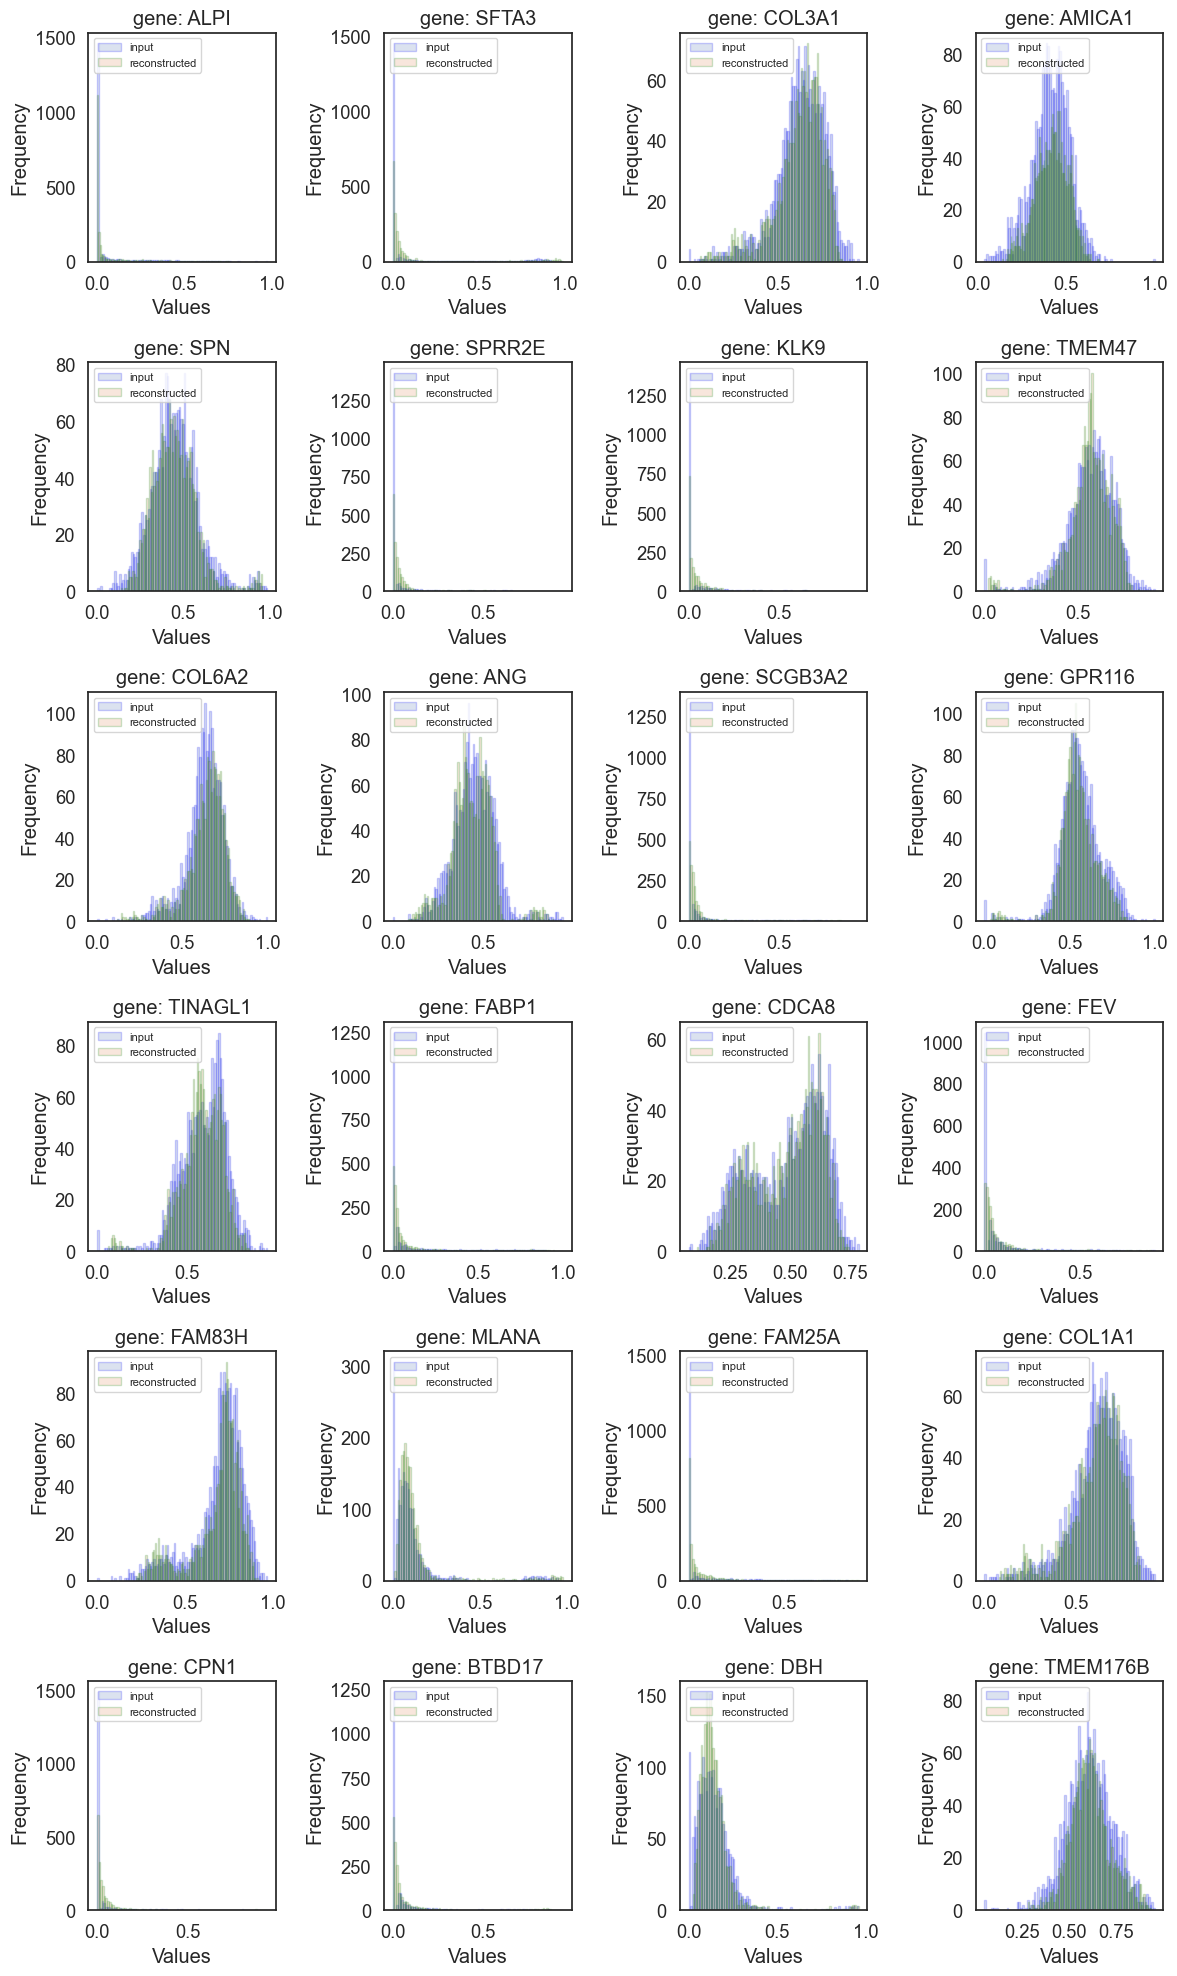

In [379]:
# gene with good reconstruction
model = load_trained_model(model, model_name=models[3])
plot_histograms_best_genes(rnaseq_df, model)

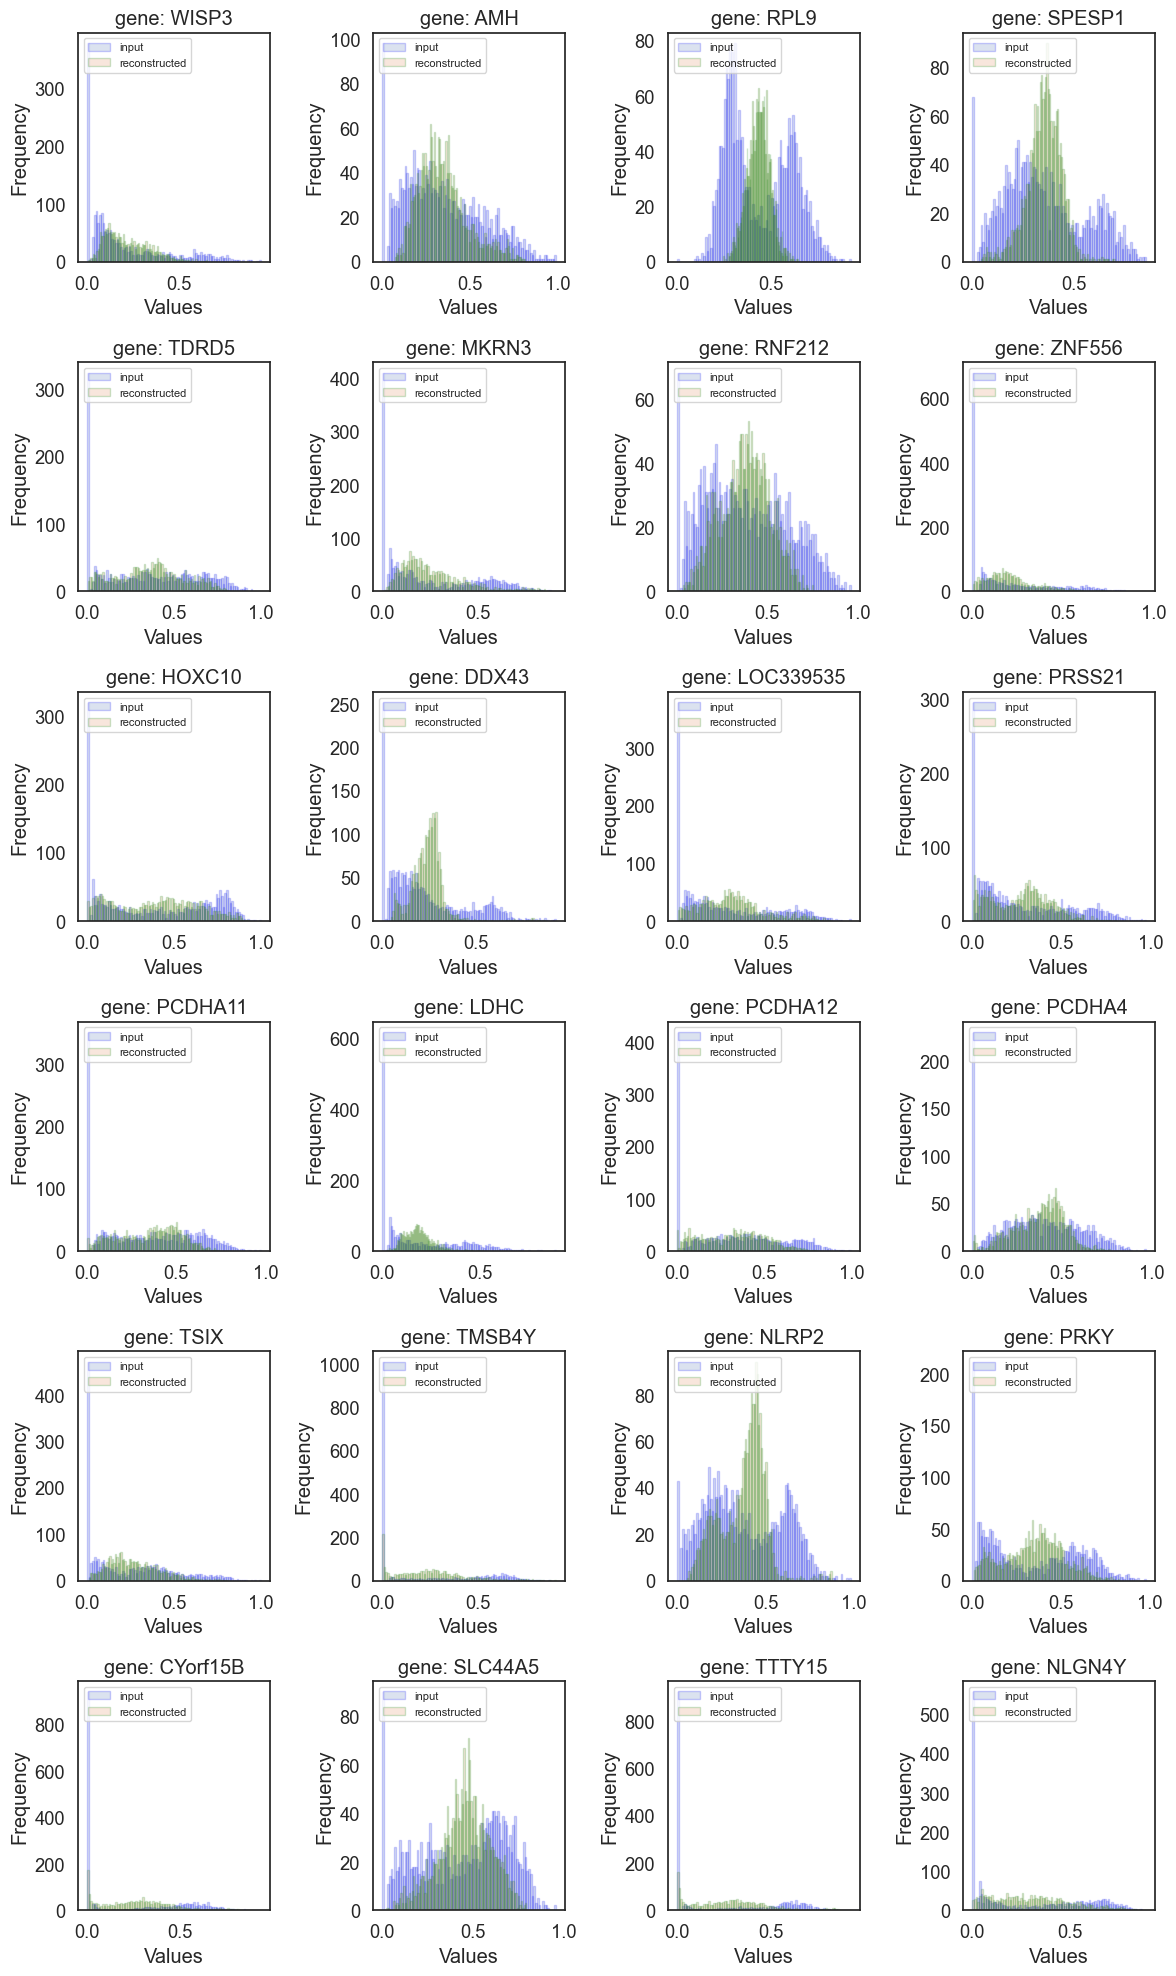

In [380]:
# results where reconstruction does not look good
plot_histograms_worst_genes(rnaseq_df, model)

#### Add noise and look at how reconstruction chnages 

In [292]:
# Define function to add gussian noise with different variance to each element of a pandas dataframe
def add_gaussian_noise(df, variances):
    assert len(variances) == len(
        df.columns
    ), "Number of variances must match the number of columns in the DataFrame."

    # Create a DataFrame with the same shape as the input DataFrame, filled with Gaussian random noise
    noise = pd.DataFrame(
        np.random.normal(0, np.sqrt(variances), size=df.shape), columns=df.columns
    )

    # Add the noise to the input DataFrame
    noisy_df = df + noise

    return noisy_df


# generate variances vector with a given upper values of maximum variance
def variance_vec(max_var, df):
    variances = np.linspace(0, max_var, len(df.columns))
    np.random.shuffle(variances)
    return variances

In [293]:
dataset_names_max_var = {
    "tcga_rnaseq_df_0p" + str(int(i * 100)): round(i, 2)
    for i in np.linspace(0.01, 0.9, 6)
}

In [294]:
# create a dictionary containing datasets with variable noises
noisy_datasets = {}
for i in dataset_names_max_var.keys():
    variance = variance_vec(dataset_names_max_var[i], rnaseq_df)
    noisy_datasets[i] = add_gaussian_noise(rnaseq_df, variance)

In [295]:
noisy_datasets.keys()

dict_keys(['tcga_rnaseq_df_0p1', 'tcga_rnaseq_df_0p18', 'tcga_rnaseq_df_0p36', 'tcga_rnaseq_df_0p54', 'tcga_rnaseq_df_0p72', 'tcga_rnaseq_df_0p90'])

In [296]:
# plot best and worst genes before and after adding noise
def plot_hist_orig_vs_noisy_best_genes(df, model, df_noisy):
    # Define the number of rows and columns in the subplot grid
    num_rows = 6
    num_cols = 4

    df_reconstruct = VAE_reconstruct_df(df, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    best_500_genes = list(gene_summary_sort.index[:500])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[best_500_genes[70 + i]],
            bins=100,
            alpha=0.3,
            edgecolor="blue",
            linewidth=1,
        )
        ax.hist(
            df_noisy[best_500_genes[70 + i]],
            bins=100,
            alpha=0.3,
            edgecolor="green",
            linewidth=1,
        )
        ax.set_title(f"gene: {str(best_500_genes[70+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(["input", "after adding noise"], fontsize="8", loc="upper left")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

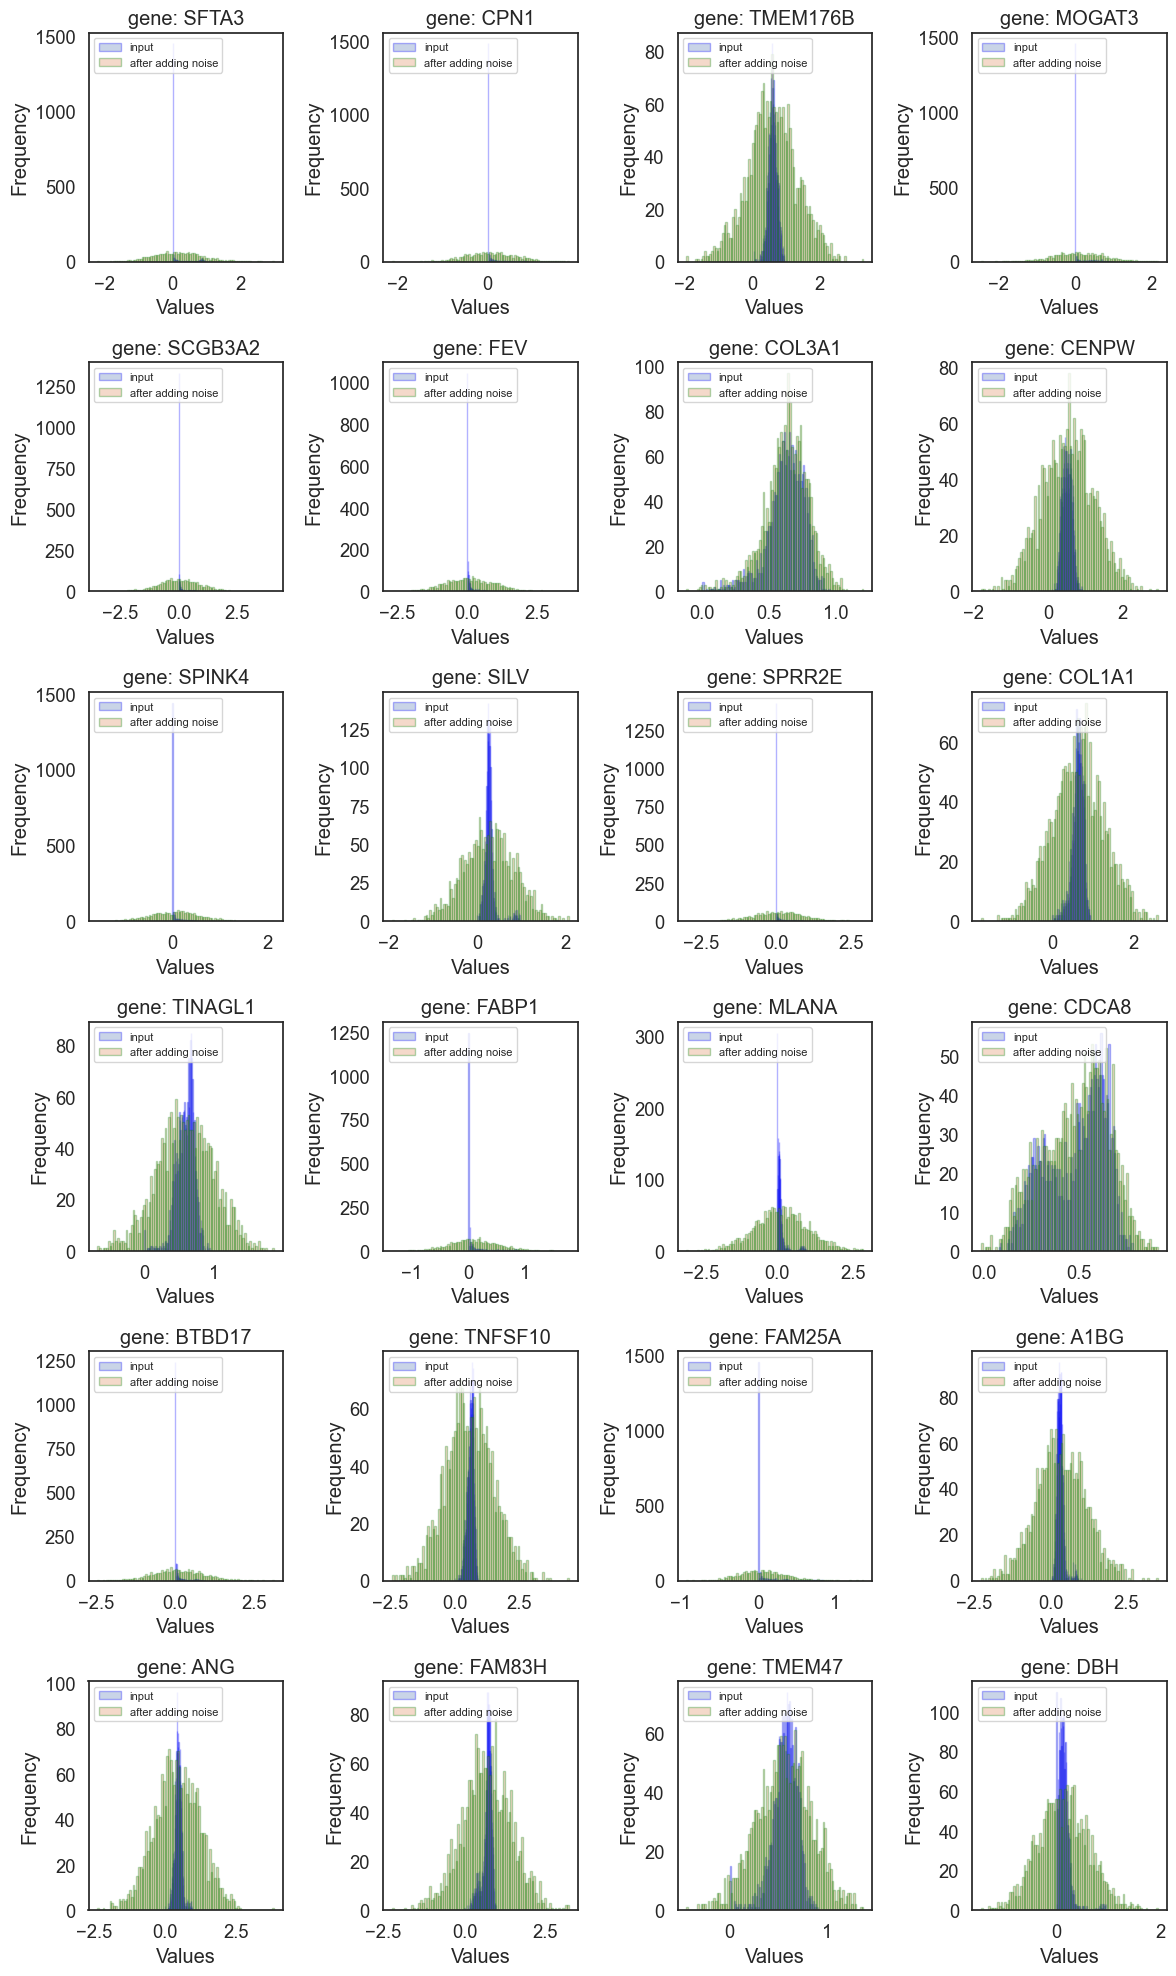

In [297]:
plot_hist_orig_vs_noisy_best_genes(rnaseq_df, model, df_noise)

In [298]:
# plot histograms for the genes which have best recontructions
def noise_recon_hist_best_genes(df, model, df_noise):
    # Define the number of rows and columns in the subplot grid
    num_rows = 3
    num_cols = 3

    df_reconstruct = VAE_reconstruct_df(df, model)
    df_reconstruct_noisy = VAE_reconstruct_df(df_noise, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    best_500_genes = list(gene_summary_sort.index[:500])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[best_500_genes[60 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="blue",
            linewidth=1,
        )
        ax.hist(
            df_reconstruct[best_500_genes[60 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="green",
            linewidth=1,
        )
        ax.hist(
            df_reconstruct_noisy[best_500_genes[60 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="orange",
            linewidth=1,
        )
        ax.set_title(f"gene: {str(best_500_genes[60+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(
            ["input", "reconst orig", "reconst noise 0.9 GN"],
            fontsize="8",
            loc="upper left",
        )

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

In [299]:
df_noise = noisy_datasets["tcga_rnaseq_df_0p90"]

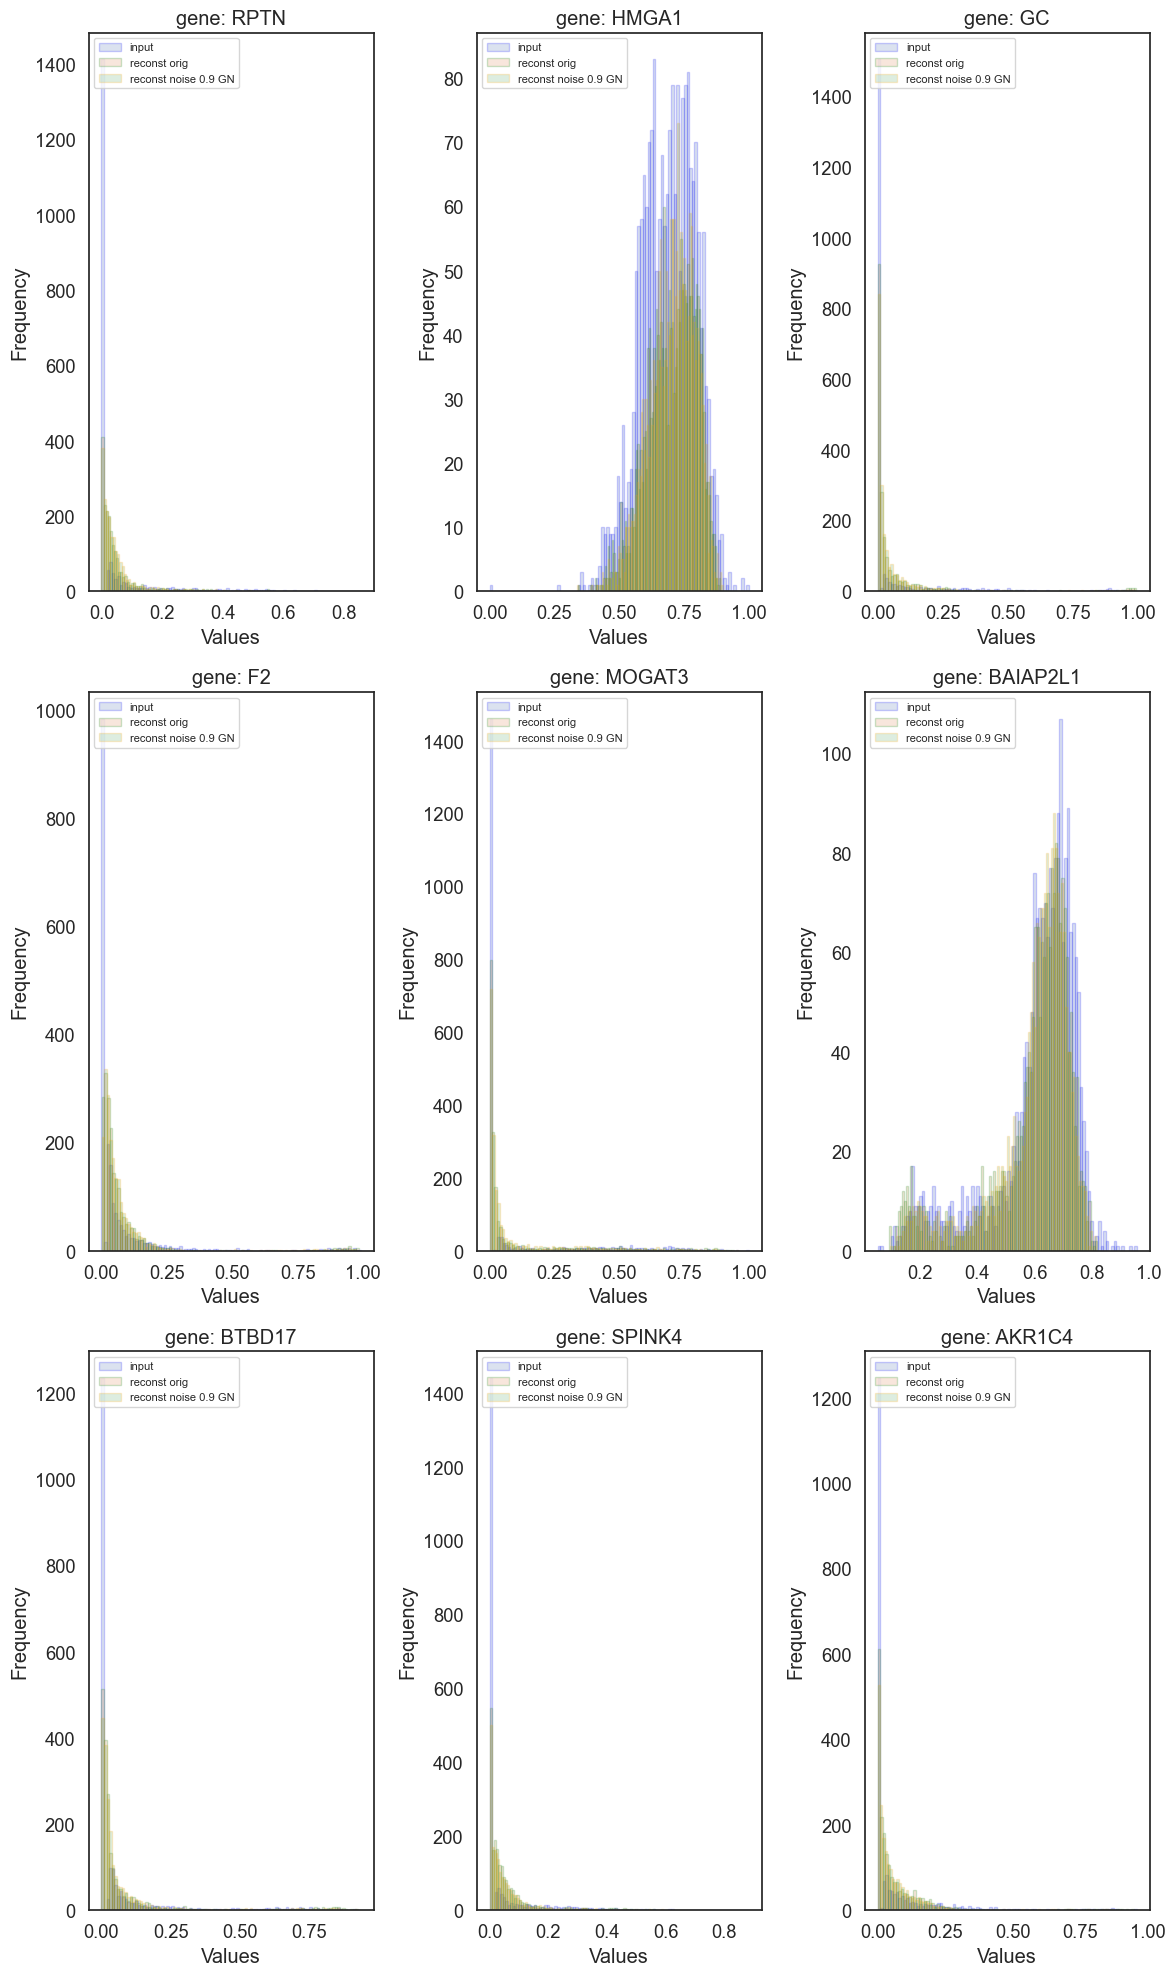

In [300]:
noise_recon_hist_best_genes(rnaseq_df, model, df_noise)

In [301]:
# plot histograms for the genes which have best recontructions
def noise_recon_hist_worst_genes(df, model, df_noise):
    # Define the number of rows and columns in the subplot grid
    num_rows = 3
    num_cols = 3

    df_reconstruct = VAE_reconstruct_df(df, model)
    df_reconstruct_noisy = VAE_reconstruct_df(df_noise, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    worst_500_genes = list(gene_summary_sort.index[-500:])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[worst_500_genes[460 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="blue",
            linewidth=1,
        )
        ax.hist(
            df_reconstruct[worst_500_genes[460 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="orange",
            linewidth=1,
        )
        ax.hist(
            df_reconstruct_noisy[worst_500_genes[460 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="green",
            linewidth=1,
        )
        ax.set_title(f"gene: {str(worst_500_genes[460+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(
            ["input", "reconst orig", "reconst noise 0.9 GN"],
            fontsize="8",
            loc="upper left",
        )

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

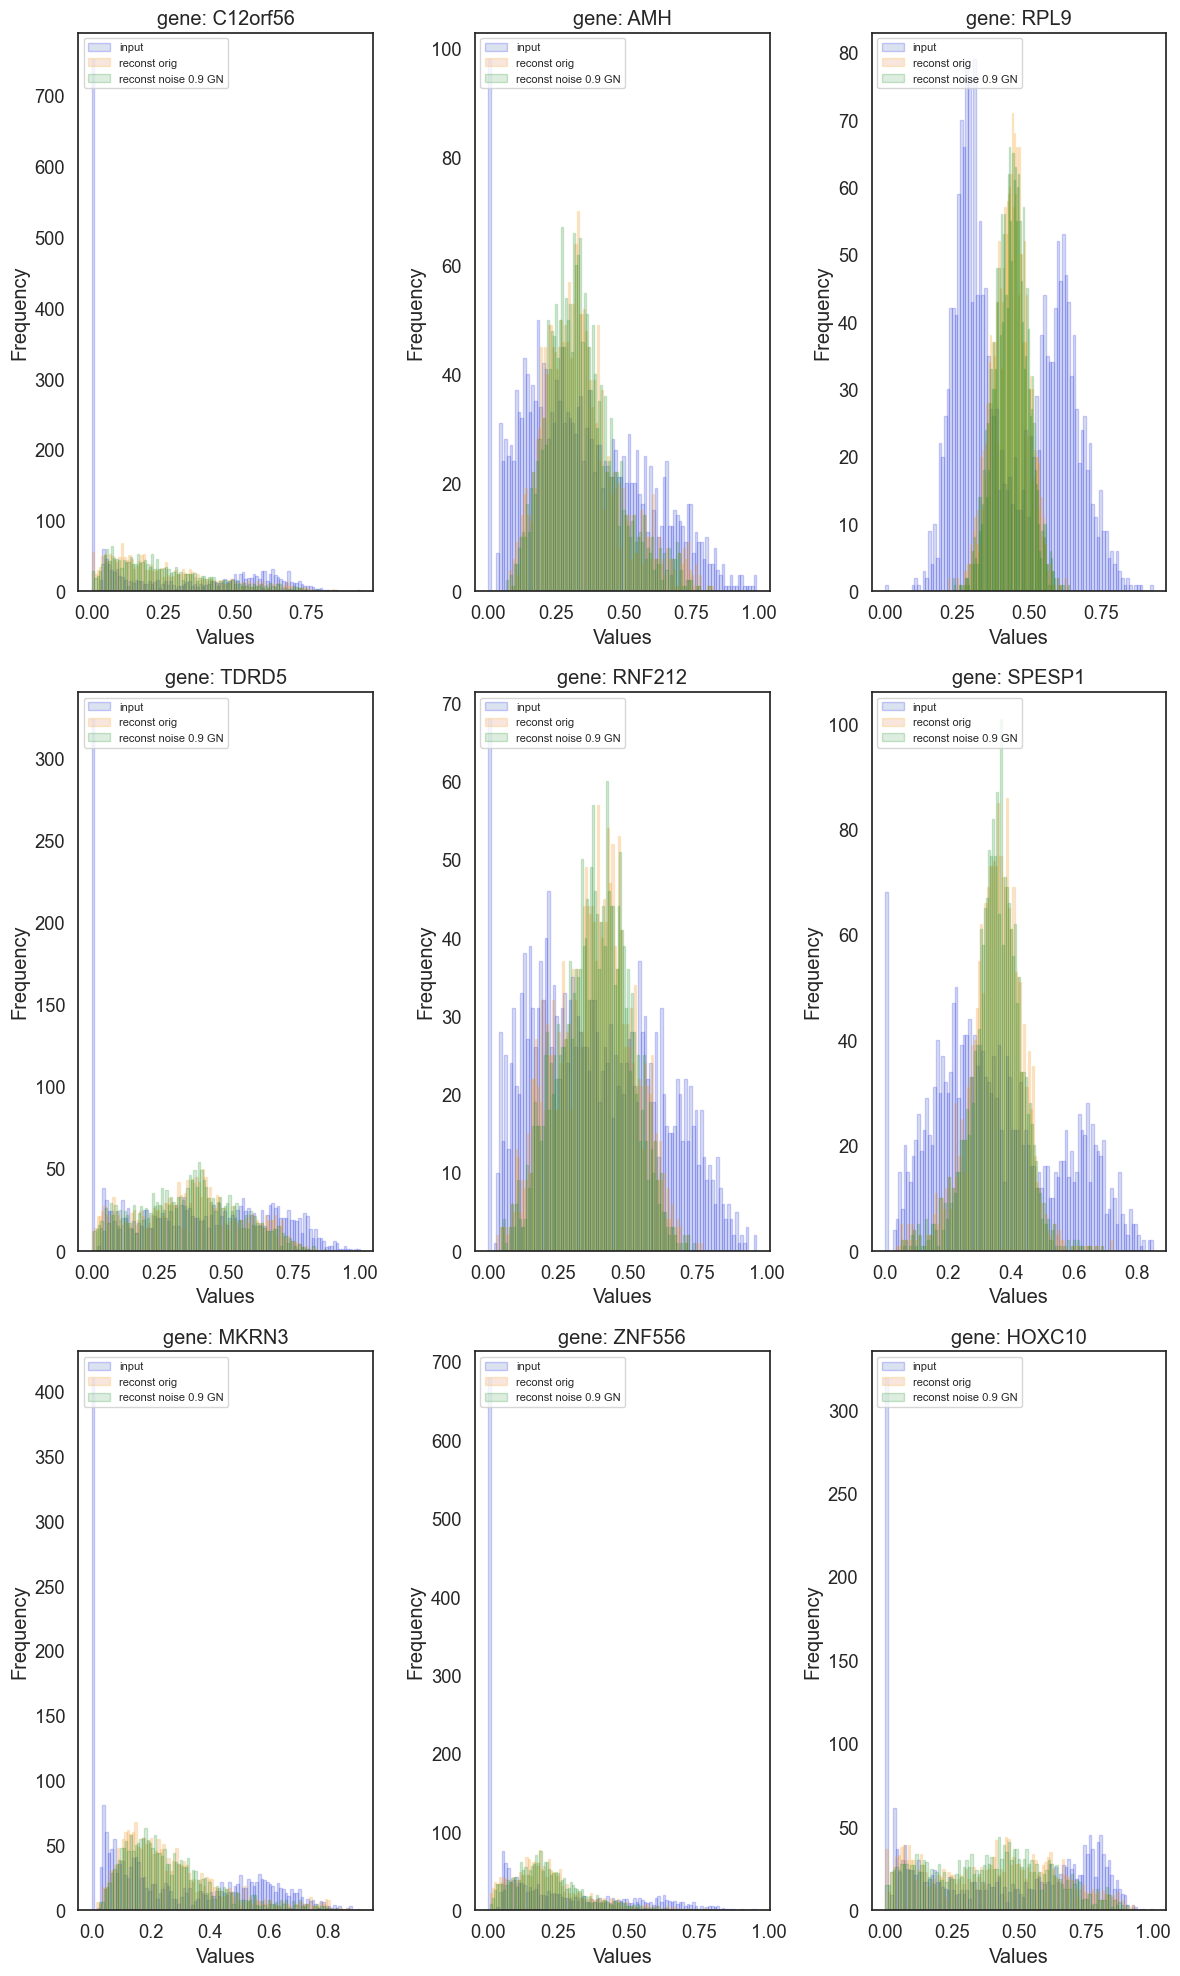

In [302]:
noise_recon_hist_worst_genes(rnaseq_df, model, df_noise)

### Look at the latent space after adding noise

In [335]:
noisy_datasets.keys()

dict_keys(['tcga_rnaseq_df_0p1', 'tcga_rnaseq_df_0p18', 'tcga_rnaseq_df_0p36', 'tcga_rnaseq_df_0p54', 'tcga_rnaseq_df_0p72', 'tcga_rnaseq_df_0p90'])

In [336]:
latent_mu, latent_sigma = VAE_latent_out(rnaseq_df)
latent_mu_noisy, latent_sigma_noisy = VAE_latent_out(
    noisy_datasets["tcga_rnaseq_df_0p90"]
)

In [337]:
# randomly select 15 columns in the latend space
random_column_num = [str(random.randint(0, 99)) for _ in range(24)]

In [339]:
latent_mu_sort = latent_mu[random_column_num]
latent_sigma_sort = latent_sigma[random_column_num]
latent_mu_sort_noisy = latent_mu_noisy[random_column_num]
latent_sigma_sort_noisy = latent_sigma_noisy[random_column_num]

In [342]:
# plot histograms for the letent space before and after adding noise
def plot_histograms_latent(df, df_noisy):
    # Define the number of rows and columns in the subplot grid
    num_rows = 6
    num_cols = 4

    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(df[df.columns[i]], bins=100, alpha=0.2, edgecolor="blue", linewidth=1)
        ax.hist(
            df_noisy[df.columns[i]], bins=100, alpha=0.2, edgecolor="green", linewidth=1
        )
        ax.set_title(f"letent: {str(df.columns[i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(["Original input", "Noisy input"], fontsize="8", loc="upper left")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

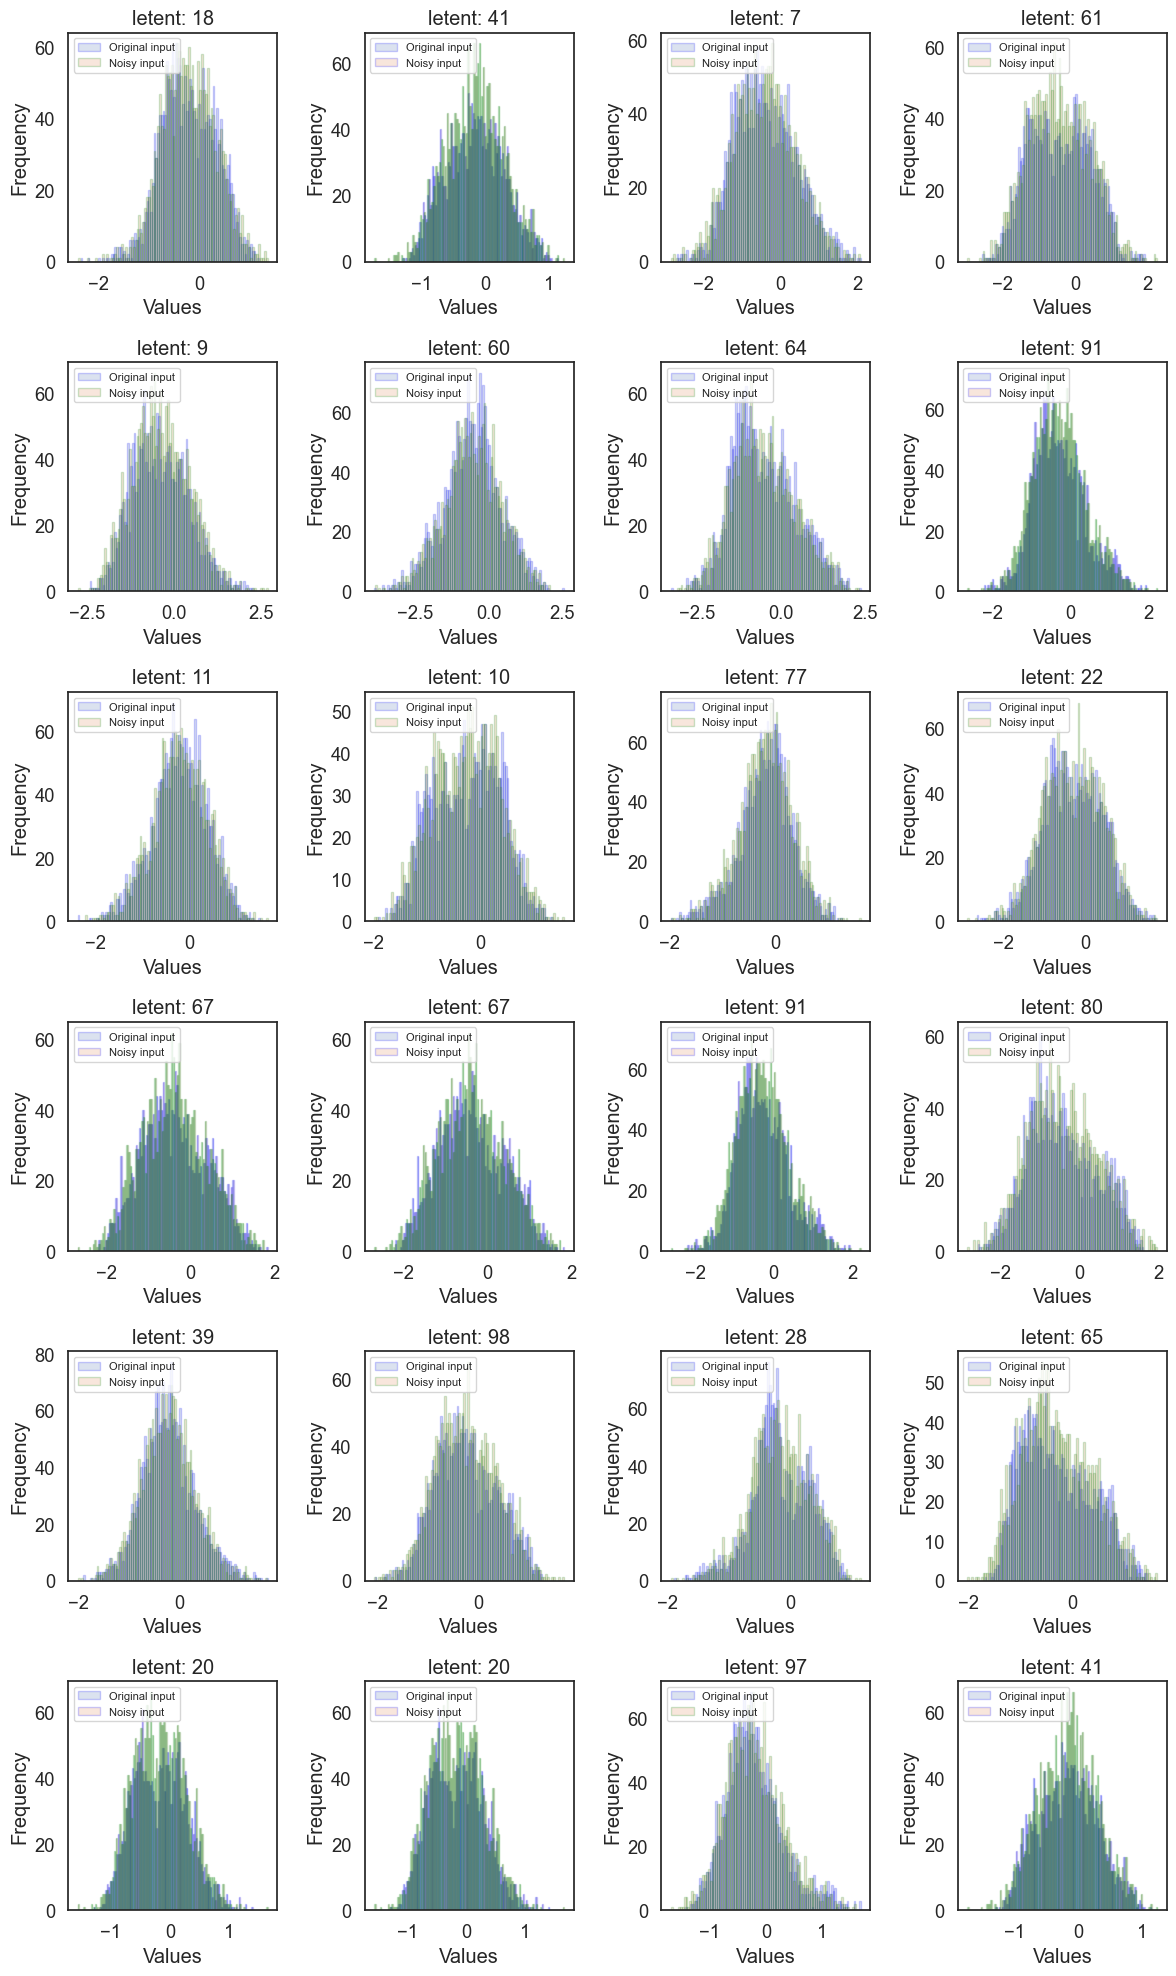

In [343]:
plot_histograms_latent(latent_mu_sort, latent_mu_sort_noisy)

#### Compute impact of adding noise to MSEs for genes with best reconstruction

In [354]:
# compute mse and bce between letent output and noisy latent output. Noisy here refers to latent data generated when input is noisy
def compute_latent_losses(df_true, df_pred):
    # Initialize an empty list to store the MSE values for each row
    mse_values = []

    # Loop through the rows of the DataFrames
    for index, row_true in df_true.iterrows():
        row_pred = df_pred.iloc[index]

        # Compute the MSE for the current row and append it to the mse_values list
        mse = mean_squared_error(row_true, row_pred)
        mse_values.append(mse)

    return mse_values

In [371]:
latent_mu, latent_var = VAE_latent_out(rnaseq_df)
means_mu = []
stds_mu = []
means_var = []
stds_var = []
for filename in noisy_datasets.keys():
    latent_mu_noisy, latent_var_noisy = VAE_latent_out(noisy_datasets[filename])

    latent_loss_mu = compute_latent_losses(latent_mu, latent_mu_noisy)
    latent_loss_var = compute_latent_losses(latent_var, latent_var_noisy)

    mean_mu = np.mean(latent_loss_mu)
    mean_var = np.mean(latent_loss_var)

    std_mu = np.std(latent_loss_mu)
    std_var = np.std(latent_loss_var)

    means_mu.append(mean_mu)
    means_var.append(mean_var)
    stds_mu.append(std_mu)
    stds_var.append(std_var)

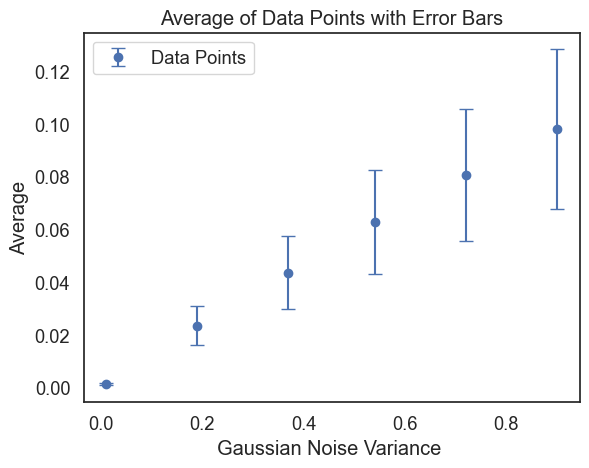

In [377]:
import matplotlib.pyplot as plt

x_values = [dataset_names_max_var[i] for i in dataset_names_max_var.keys()]
# Plot the average values with error bars
plt.errorbar(x_values, means_mu, yerr=stds_mu, fmt="o", capsize=5, label="Data Points")

# Add labels and a title
plt.xlabel("Gaussian Noise Variance ")
plt.ylabel("Average")
plt.title("Average of Data Points with Error Bars")

# Display a legend
plt.legend()

# Show the plot
plt.show()

#### Check how permutation impact the above results

Let's see how results look with random permutation for earch row

In [386]:
# Each row is shuffled randomly
def shuffle_random_subset_rows(df, subset_size):
    """
    Shuffles a random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    for i in range(len(df_shuffled)):
        subset_cols = np.random.choice(num_cols, subset_size, replace=False)
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(
            df_shuffled.iloc[i, subset_cols]
        )
    return df_shuffled


def generate_n_integers_uniform(n):
    random_integers = np.random.uniform(low=0, high=101, size=n).astype(int)
    return sorted(random_integers)

In [387]:
percent_shuffled = generate_n_integers_uniform(n=10)

In [393]:
shuffled_dataset = {
    "rnaseq_df_suffled_"
    + str(i): shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1] * i / 100))
    for i in percent_shuffled
}

In [394]:
shuffled_dataset.keys()

dict_keys(['rnaseq_df_suffled_14', 'rnaseq_df_suffled_24', 'rnaseq_df_suffled_49', 'rnaseq_df_suffled_67', 'rnaseq_df_suffled_73', 'rnaseq_df_suffled_76', 'rnaseq_df_suffled_91', 'rnaseq_df_suffled_99'])

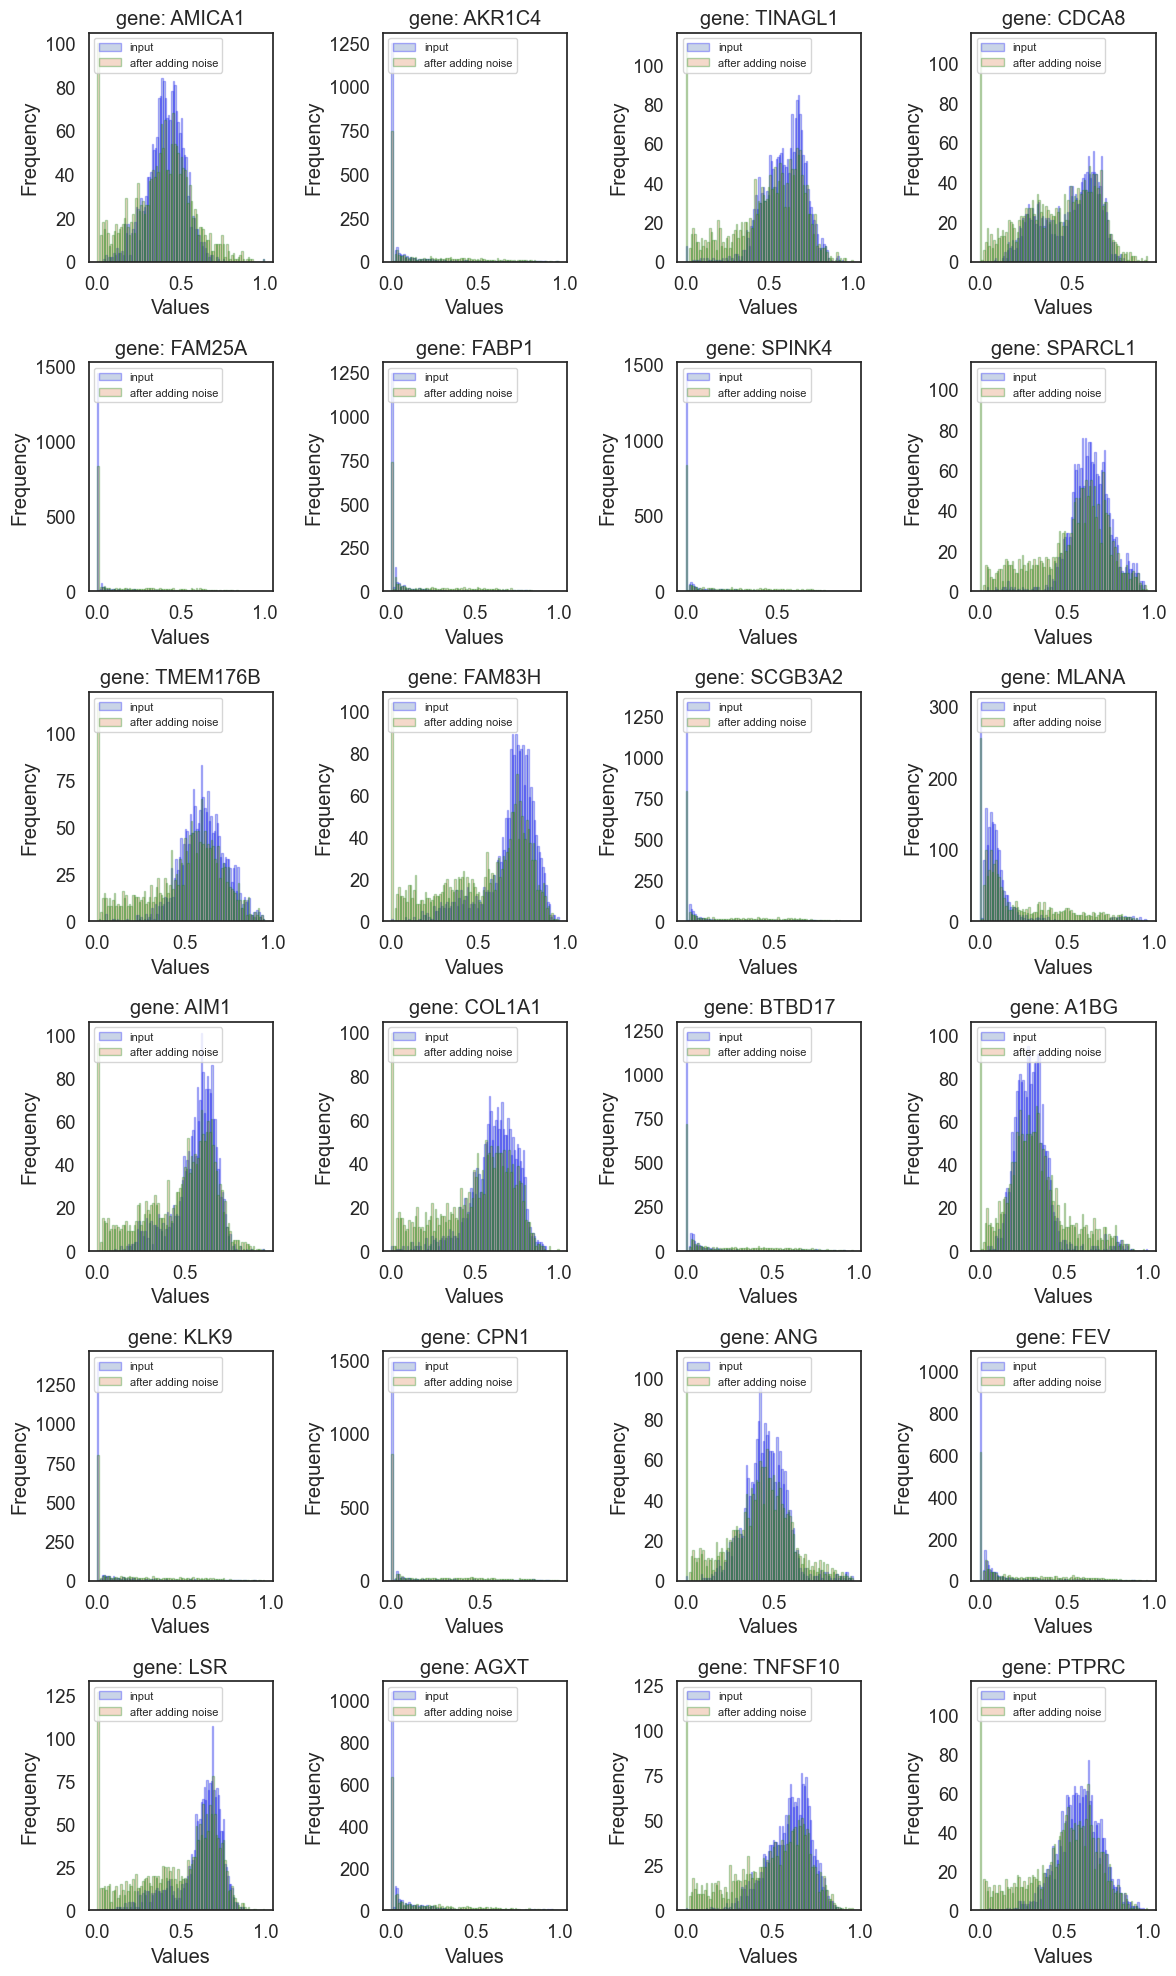

In [401]:
plot_hist_orig_vs_noisy_best_genes(
    rnaseq_df, model, shuffled_dataset["rnaseq_df_suffled_49"]
)

In [402]:
# plot histograms for the genes which have best recontructions
def shuffled_recon_hist_best_genes(df, model, df_noise):
    # Define the number of rows and columns in the subplot grid
    num_rows = 3
    num_cols = 3

    df_reconstruct = VAE_reconstruct_df(df, model)
    df_reconstruct_noisy = VAE_reconstruct_df(df_noise, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    best_500_genes = list(gene_summary_sort.index[:500])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[best_500_genes[60 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="blue",
            linewidth=1,
        )
        ax.hist(
            df_reconstruct[best_500_genes[60 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="green",
            linewidth=1,
        )
        ax.hist(
            df_reconstruct_noisy[best_500_genes[60 + i]],
            bins=100,
            alpha=0.2,
            edgecolor="orange",
            linewidth=1,
        )
        ax.set_title(f"gene: {str(best_500_genes[60+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(
            ["input", "reconst orig", "shuffled"],
            fontsize="8",
            loc="upper left",
        )

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

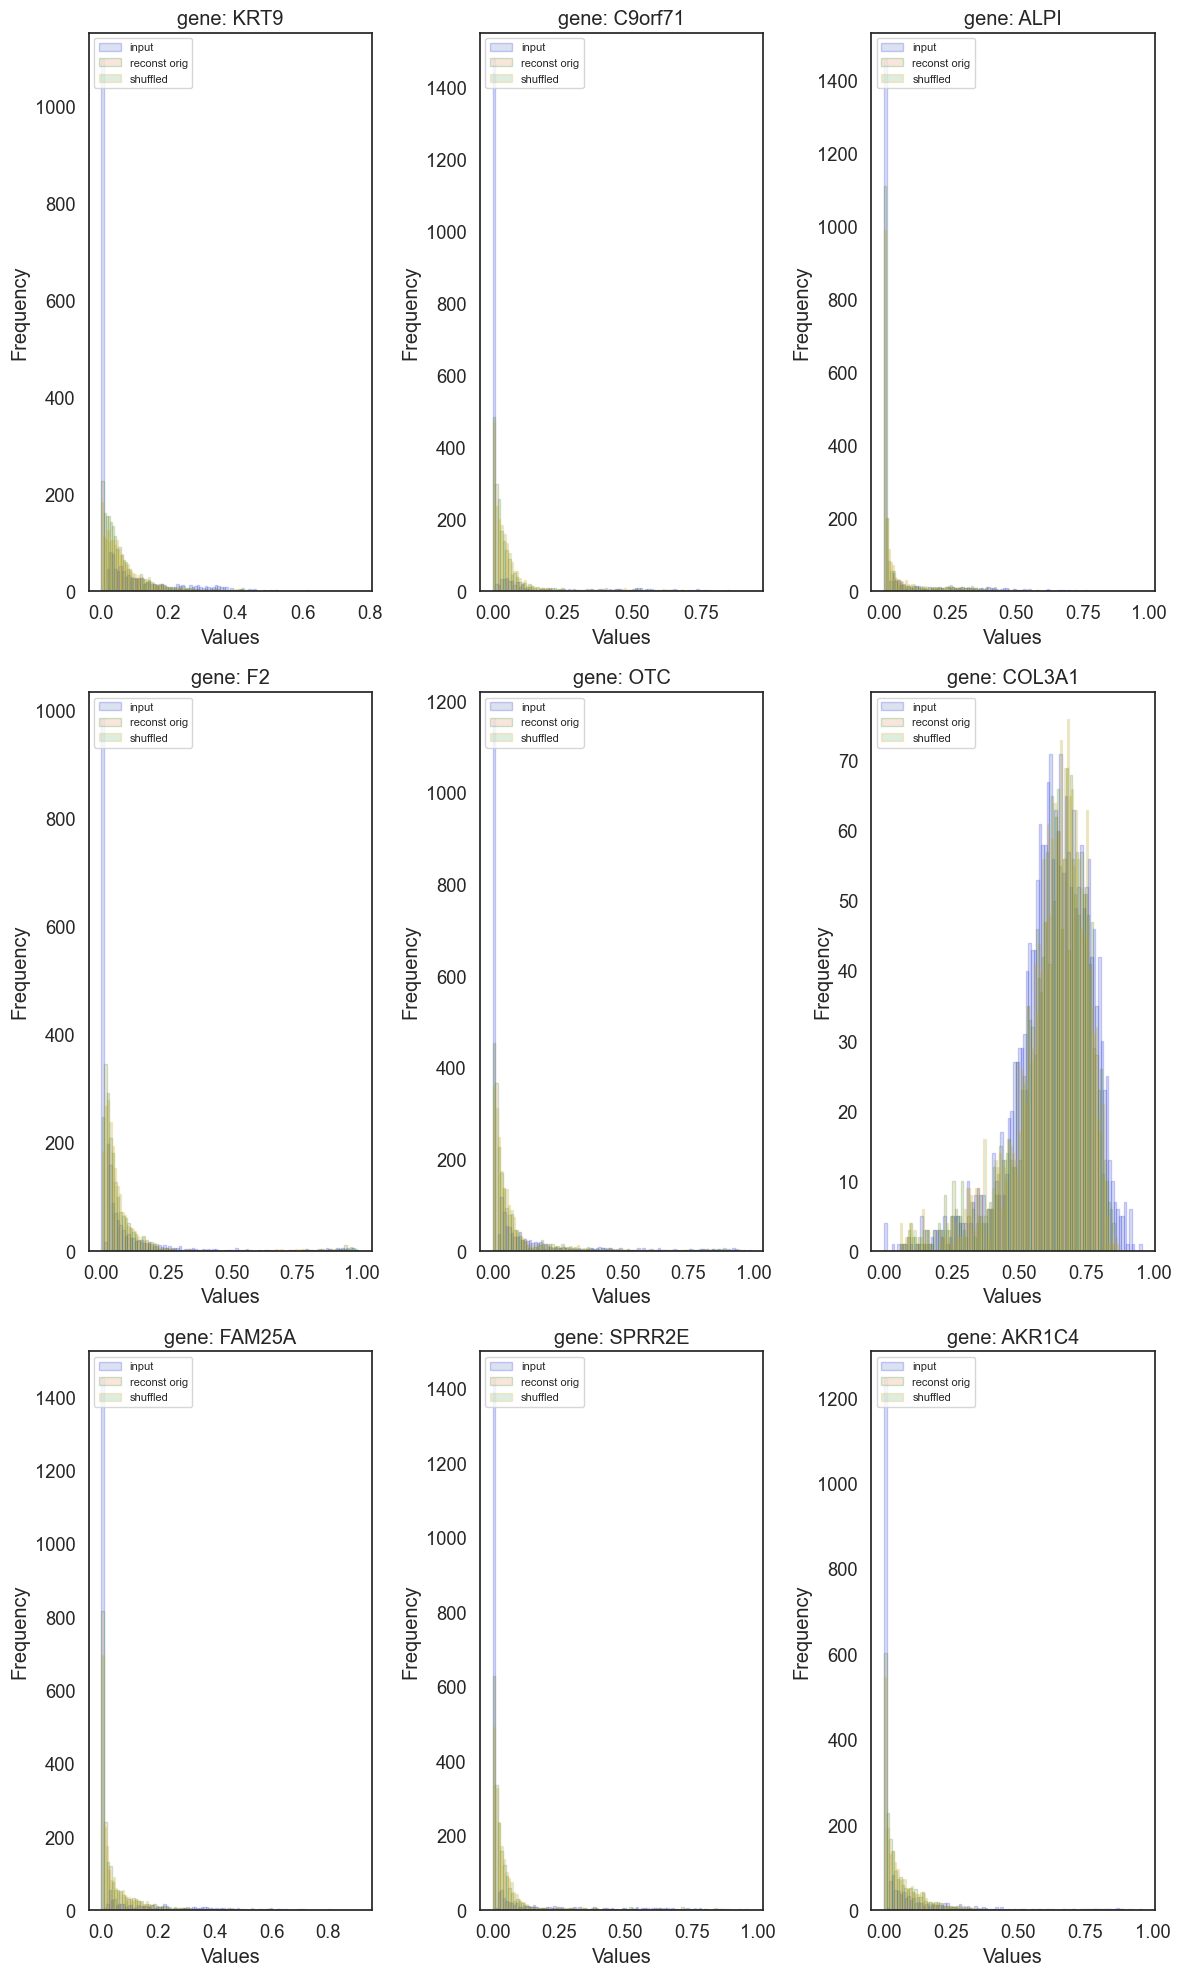

In [403]:
shuffled_recon_hist_best_genes(
    rnaseq_df, model, shuffled_dataset["rnaseq_df_suffled_49"]
)

Look at the latent space

In [404]:
latent_mu_shuffled, latent_sigma_shuffled = VAE_latent_out(
    shuffled_dataset["rnaseq_df_suffled_49"]
)

In [405]:
latent_mu_shuffled_sort = latent_mu_shuffled[random_column_num]
latent_sigma_shuffled_sort = latent_sigma_shuffled[random_column_num]

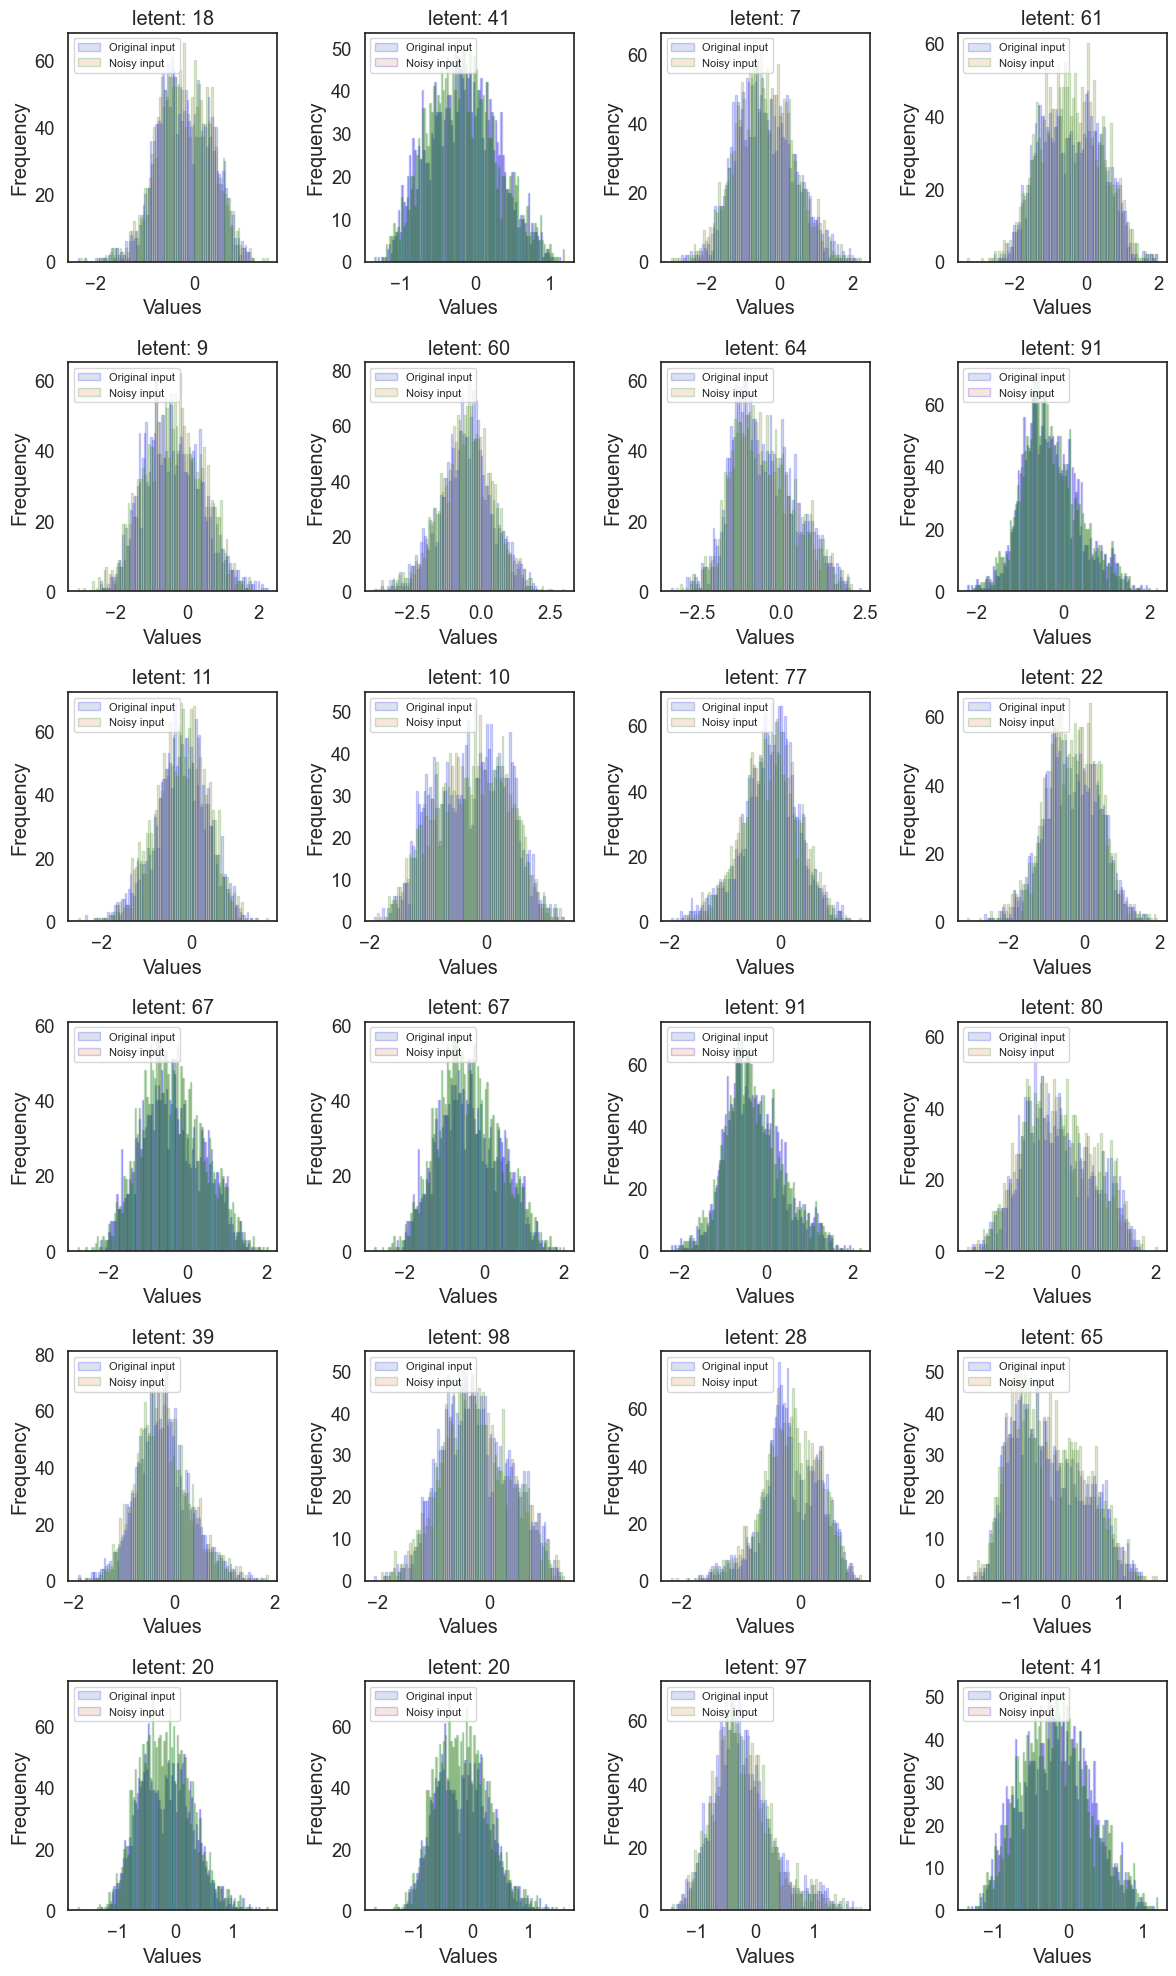

In [406]:
plot_histograms_latent(latent_mu_sort, latent_mu_shuffled_sort)